# Imports

In [ ]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [ ]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

In [ ]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

### Prepare workdir

In [ ]:
from pathlib import Path
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

### Imports...

In [ ]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

### Query DB for contact IDs

#### Load meta data CSV

In [ ]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'])
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'])

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)
stats

## Fetch fresh docs from Mongo DB

In [ ]:
from datetime import date
from dateutil.relativedelta import relativedelta

# lastdate = date.today() + relativedelta(months=-2)
# lastdate = datetime.combine(lastdate, datetime.min.time())

# lastdate

In [ ]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType": "CONTRACT"},
      
    {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(1000)

res = list([i for i in res])

_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

# Prepare training set

In [92]:
from tf_support.super_contract_model import seq_labels_contract
seq_labels_contract

['headline_h1',
 'subject',
 '_reserved',
 'date',
 'number',
 'org-1-name',
 'org-1-type',
 'org-1-alias',
 'org-2-name',
 'org-2-type',
 'org-2-alias',
 'sign_value_currency/value',
 'sign_value_currency/currency',
 'sign_value_currency/sign']

In [126]:
docs_ids = [i["_id"] for i in res]
sample_id = docs_ids[0]
sample_id

ObjectId('5fca2aae9083b679224c7614')

In [127]:
from bson import ObjectId
# sample_id = ObjectId('60002adfb08473039387bcd6')
d = get_doc_by_id(sample_id)

jd = DbJsonDoc(d)
jd

/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [128]:
# jd.get_attributes_tree()

2.0.5


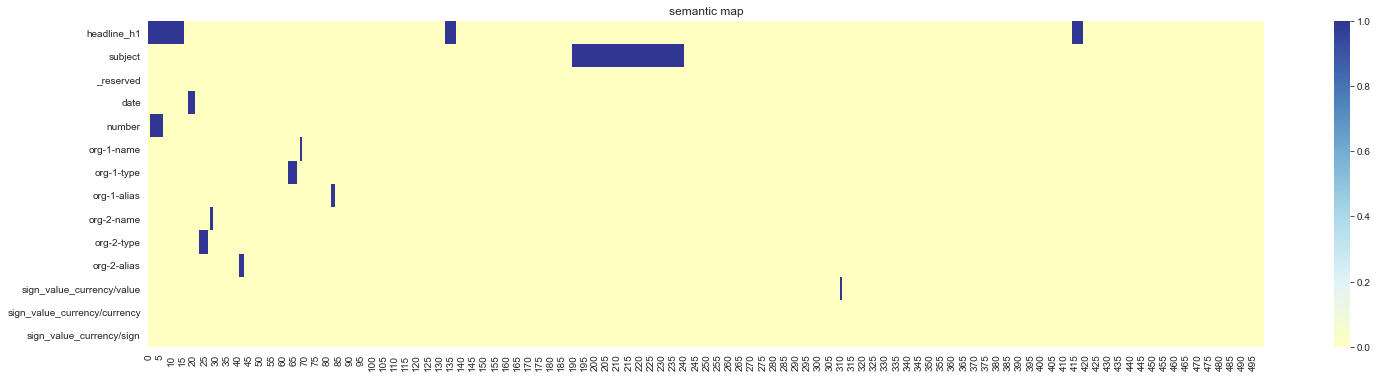

In [129]:
from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding
import numpy as np


# from trainsets.retrain_contract_uber_model import flatten_attributes_tree


#XXX: replace with DbJsonDoc.get_version_string
def get_version(d: DbJsonDoc):
  attr_tree = d.get_attributes_tree()
  if 'version' in attr_tree:
    return '.'.join([str(x) for x in attr_tree['version']])
  else:
    return d.analysis['version']


def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')

  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = get_version(d)
    
 
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = d.analysis['analyze_timestamp']


  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')
    
  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    


  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = d.user[
      'updateDate']  # find_in_dict('attributes_tree.creation_date', d.user)

    
    
#==========================
    
print(get_version(jd))
# print(jd.get_attributes_tree().get('price', {}).get('amount_netto', {}).get('value')   )
# print(jd.get_attributes_tree().get('orgs', [{},{}])[0].get('name', {}).get('value'))
add_stats_record(jd, stats)
# stats.tail()
# jd.get_attributes_tree()



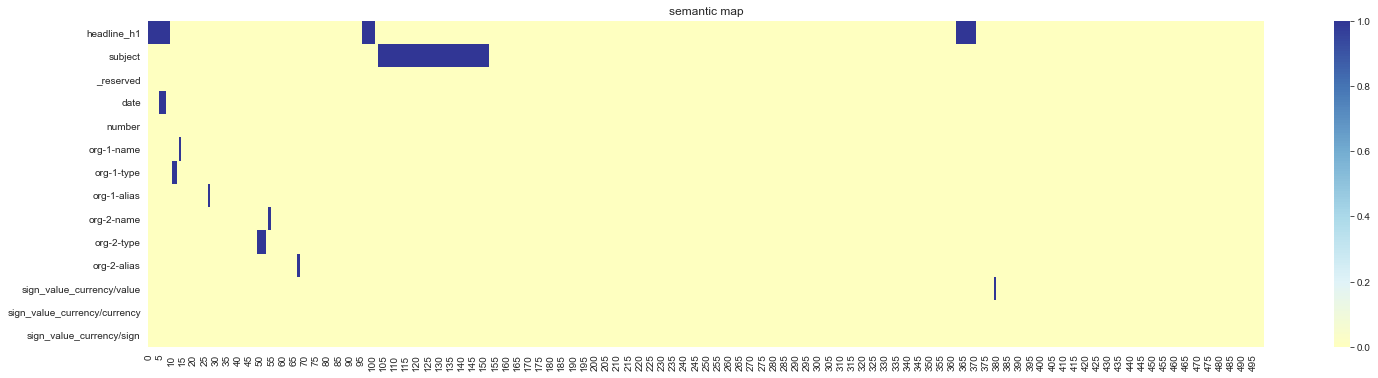

In [152]:

def get_semantic_map(doc: DbJsonDoc):
    attr_tree = doc.get_attributes_tree()
    _len = len(doc)
    df = DataFrame()
    for sl in seq_labels_contract:    
        df[sl] = np.zeros(_len)
        
    av = np.zeros(_len)
    headers = doc.analysis['headers']
    for h in headers:
        av[h['span'][0]:h['span'][1]] = 1.0
    
    df['headline_h1'] = av
    
    def add_av(name, span, av=None):
        if av is None:            
            av = np.zeros(_len)
        if span:
            av[span[0]:span[1]] = 1.0
        df[name] = av
 
    
    for n in ['subject', 'date', 'number']:
        add_av(n, attr_tree.get(n, {}).get('span'))
        
    for i in [1, 2]:
        for n in ['name', 'alias', 'type']:
            try:
                add_av(f'org-{i}-{n}', attr_tree['orgs'][i-1][n]['span'])
            except Exception as e:
                print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs'))

            
 
    _value_tag = attr_tree.get('price')
  
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_av('sign_value_currency/value', amount.get('span'))
        add_av('sign_value_currency/currency', _value_tag.get('currency',{}).get('span'))
        add_av('sign_value_currency/currency', _value_tag.get('sign',{}).get('span'))
            
    return df

 
    
plot_embedding(get_semantic_map(jd)[:500], 'semantic map')

In [153]:
print(len(docs_ids))

2


In [154]:
for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    
    try:
        add_stats_record(jd, stats)
    except Exception as e:
        print(jd.get_id())
        raise (e)
    
    if k % 20 == 0:
        print(f'{k} of {len(docs_ids)}')
        stats.to_csv(export_fn, index=True)
    
stats.to_csv(export_fn, index=True)
stats

0 of 2


,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,NaN,2.969460e+07,2021-08-25 14:15:51.680,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-10-20 13:21:38.682880,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167d79187f1d9065bb8b94b,NaN,2.5.0,Газпром нефть,Тюльпан,Заказчик,Исполнитель,Service,NaN,2021-10-14 07:21:37.988,2021-10-14 10:12:40.413,88fc45d9053c41b2ab7dc5d8c65f1bb3,2021-10-20 13:23:54.968399,1.000000,NaN,NaN,NaN,NaN,7226.0
6167d81a87f1d9065bb8b950,NaN,2.5.0,Газпром нефть,Гладиолус,Заказчик,Исполнитель,Service,1.200000e+04,NaT,2021-10-14 10:15:24.709,0e12ea6bd5faf366fce0c9e0a24d4565,2021-10-20 13:23:55.441982,0.945099,9.392745,3595.0,NaN,RUB,4238.0
6167e45b87f1d9065bb8b953,NaN,2.5.0,Газпром нефть,Хризантема,ЭМИТЕНТ,РЕГИСТРАТОР,Service,NaN,NaT,2021-10-14 11:06:06.967,12a420134f2a47ac5a61e6fa83b64969,2021-10-20 13:23:55.924223,0.996957,NaN,NaN,NaN,NaN,3937.0
6167e8ea87f1d9065bb8b956,NaN,2.5.0,Сибирская нефтяная компания,Специализированный регистратор - Держатель рее...,Эмитент,Регистратор,Service,NaN,2021-10-14 09:39:52.493,2021-10-14 11:26:01.673,23594ee3e50c4ae3f31ba2972de6b915,2021-10-20 13:23:56.851262,1.000000,NaN,NaN,NaN,NaN,5956.0


In [155]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,NaN,2.969460e+07,2021-08-25 14:15:51.680,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-10-20 13:21:38.682880,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167d79187f1d9065bb8b94b,NaN,2.5.0,газпром нефть,тюльпан,заказчик,исполнитель,Service,NaN,2021-10-14 07:21:37.988,2021-10-14 10:12:40.413,88fc45d9053c41b2ab7dc5d8c65f1bb3,2021-10-20 13:23:54.968399,1.000000,NaN,NaN,NaN,NaN,7226.0
6167d81a87f1d9065bb8b950,NaN,2.5.0,газпром нефть,гладиолус,заказчик,исполнитель,Service,1.200000e+04,NaT,2021-10-14 10:15:24.709,0e12ea6bd5faf366fce0c9e0a24d4565,2021-10-20 13:23:55.441982,0.945099,9.392745,3595.0,NaN,RUB,4238.0
6167e45b87f1d9065bb8b953,NaN,2.5.0,газпром нефть,хризантема,эмитент,регистратор,Service,NaN,NaT,2021-10-14 11:06:06.967,12a420134f2a47ac5a61e6fa83b64969,2021-10-20 13:23:55.924223,0.996957,NaN,NaN,NaN,NaN,3937.0
6167e8ea87f1d9065bb8b956,NaN,2.5.0,сибирская нефтяная компания,специализированный регистратор - держатель рее...,эмитент,регистратор,Service,NaN,2021-10-14 09:39:52.493,2021-10-14 11:26:01.673,23594ee3e50c4ae3f31ba2972de6b915,2021-10-20 13:23:56.851262,1.000000,NaN,NaN,NaN,NaN,5956.0


In [156]:
stats2['subject'].value_counts()

Service                              1272
Deal                                  483
GeneralContract                       127
Renting                               119
Loans                                  95
AgencyContract                         65
Insurance                              47
DealIntellectualProperty               39
RealEstate                             38
Charity                                36
RealEstateTransactions                 25
PledgeEncumbrance                       6
BigDeal                                 6
BankGuarantees                          6
ParticipationInOtherOrganizations       5
Other                                   3
AssetTransactions                       1
DecisionsForSubsidiary                  1
Name: subject, dtype: int64

In [157]:
stats2['org-1-alias'].value_counts()

заказчик                 821
исполнитель              472
покупатель               337
продавец                  90
поставщик                 85
                        ... 
газпромнефть-терминал      1
лицензии                   1
заказии                    1
владелец свх               1
гпн                        1
Name: org-1-alias, Length: 75, dtype: int64

In [158]:
stats2['org-2-alias'].value_counts()

исполнитель      682
заказчик         507
поставщик        288
покупатель       174
подрядчик        136
                ... 
газпром нефть      1
субподрядчик       1
весна              1
компания           1
жертвователь       1
Name: org-2-alias, Length: 70, dtype: int64

In [159]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
stats2.head(40)

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score
5fe34f63b770574a005553db,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe3...,2.3.13,газпромнефть-снабжение,эта,залогодатель,залогодержатель,PledgeEncumbrance,6.000000e+07,2021-07-22 09:19:27.348,2020-12-23 17:14:31.820,b42ed28b9a72f51612db24cbd7b7a4f0,2021-07-29 14:20:42.942401,NaN,17.909855,160.0,NaN,NaN,2386.0,False,0.576329
5ec2b8d9665f7603e03b1238,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,газпромнефть-региональные продажи,нептун,залогодатель,залогодержатель,PledgeEncumbrance,6.000000e+07,2020-05-21 15:27:48.922,2020-05-21 15:29:00.410,7e9e0a5f729f876a5b3055de5076db9d,2021-07-29 14:23:59.738433,NaN,17.909855,169.0,NaN,RUB,2395.0,False,0.576329
5ec2b8da665f7603e03b127d,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,сбербанк россии,оск,кредитор,проект,Renting,1.394400e+10,2020-09-10 11:10:15.402,2020-09-10 11:10:43.308,6d075df102717d0a1291facdb16ae21e,2021-07-29 14:23:55.661347,NaN,23.358315,313.0,NaN,RUB,12174.0,False,0.685942
60b7a58e061c76d77545526f,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,газпромбанк,приказодатель,банк,Loans,3.130200e+06,2021-07-31 15:43:37.710,2021-06-05 06:22:34.302,12a28c1f993034480f13fd437253452c,2021-07-31 18:47:45.790842,NaN,14.956608,186.0,NaN,EURO,5573.0,False,1.394334
60b7a4c3061c76d7754545e3,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-аэро,субсубарендатор,субарендатор,Renting,1.080000e+04,2021-07-23 12:29:19.231,2021-06-03 03:28:32.872,94f0763cb517ebf7bcf1bcb4ba009e08,2021-07-29 14:20:31.404607,NaN,9.287394,406.0,NaN,NaN,2276.0,False,1.725183
60b7a4c3061c76d7754545da,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-ангара,управляемая организация,управляющая организация,Service,5.000000e+04,2021-06-22 13:40:54.455,2021-06-03 03:18:14.469,407261fdff9a7a1156a2e909c57311dd,2021-07-29 14:21:22.701427,NaN,10.819798,1240.0,NaN,NaN,2107.0,False,1.904743
60002adfb08473039387bcae,http://gpn-audit.nemosoft.ru/#/audit/edit/6000...,2.3.14,газпромнефть-снабжение,газпром нефть,правообладатель,приобретатель,Deal,4.400005e+07,2021-07-20 07:47:49.711,2021-01-14 14:29:31.907,772ba956e0729d7fee4509c818ae33f5,2021-07-29 14:21:13.540871,NaN,17.599701,430.0,NaN,NaN,1511.0,False,2.074317
612cdb20ea1085618e02ff0f,http://gpn-audit.nemosoft.ru/#/audit/edit/612c...,2.4.4,газпром нефть,новатэк,продавец,покупатель,DecisionsForSubsidiary,1.593133e+09,2021-10-20 10:33:35.109,2021-08-31 11:41:52.908,964e297a3b12fcb1ab0a05fc8a7a2ed1,2021-10-20 19:02:51.328300,1.0,21.188968,2751.0,NaN,RUB,11862.0,False,2.286381
60b7a4c4061c76d7754545fd,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромбанк,газпромнефть-каталитические системы,банк,приказодатель,Loans,3.000000e+09,2021-06-22 12:58:36.232,2021-06-03 03:43:10.319,25d924fc09b7291d964f464f9c3ec8c3,2021-07-29 14:21:24.874757,NaN,21.821878,337.0,NaN,RUB,8535.0,False,2.355700
5fc7a031c54bc33809e2617d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,газпром нефть,продавец,покупатель,AssetTransactions,6.900000e+08,2020-12-19 14:37:04.140,2020-12-19 17:37:19.860,78cdeaf637236f64e5ed7f97d78c2a27,2021-07-29 14:21:48.496845,NaN,20.352202,638.0,NaN,RUB,3267.0,False,2.380384


In [160]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [161]:
stats2['len'] //= 5 #similar lens
stats2['len'] *= 5 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score
5fb3b9b000881c332b56746c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 11:55:01.865,52a9649ba88d76e1f943d31db634dff4,2021-07-29 14:27:33.322139,NaN,NaN,NaN,NaN,NaN,49345.0,True,1.440000e+08
5fc7a047c54bc33809e26372,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,заказчик,NaN,Service,90619807.0,NaT,2020-12-03 08:07:48.699,82137d4b0ded9b81b1d12f4d9e98c383,2021-07-29 14:32:11.482145,NaN,18.322183,4503.0,NaN,RUB,49340.0,True,3.142624e+03
5fca2acd9083b679224c77da,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,заказчик,подрядчик,GeneralContract,90619807.0,2021-07-30 21:59:37.858,2020-12-10 10:40:36.652,6b64d52e5ecb4941696164ed4950e735,2021-07-31 18:18:15.645746,NaN,18.322183,4207.0,NaN,RUB,49045.0,False,2.623410e+01
5fc7a044c54bc33809e2634d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-12-02 14:13:46.114,2be147450a483219b8d7139324d23b03,2021-07-29 14:32:01.545688,NaN,NaN,NaN,NaN,NaN,44185.0,True,1.440000e+08
5fb3b9a800881c332b567433,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 11:54:59.086,287d93101b752b5f041d476d7196864e,2021-07-29 14:27:25.900821,NaN,NaN,NaN,NaN,NaN,44185.0,True,1.440000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a502061c76d775454acf,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-04 02:16:34.669,0e4c83130e2fa3bda54cdec67dd53694,2021-07-29 14:35:31.486684,NaN,NaN,NaN,NaN,NaN,80.0,True,7.721062e+07
615e9e978f3b0514f3f42412,http://gpn-audit.nemosoft.ru/#/audit/edit/615e...,2.4.6,газпром нефть,NaN,NaN,NaN,BankGuarantees,NaN,NaT,2021-10-07 10:15:41.812,9bc5730f6ae0574a483caa5c2ab99222,2021-10-20 13:23:37.208434,0.623219,NaN,NaN,NaN,NaN,65.0,True,7.005277e+06
612cdb23ea1085618e02ff48,http://gpn-audit.nemosoft.ru/#/audit/edit/612c...,2.4.4,газпром нефть,NaN,NaN,NaN,BankGuarantees,NaN,NaT,2021-08-31 11:44:01.295,e8d3ae2a2195510471d2bd48146dbfe3,2021-10-20 13:22:13.111976,0.707877,NaN,NaN,NaN,NaN,65.0,True,7.005277e+06
60b7a58e061c76d77545525d,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,NaN,NaT,2021-06-05 06:12:14.896,16919b50a8bbeca754edbb08c5636bb5,2021-07-29 14:38:30.637880,NaN,NaN,NaN,NaN,NaN,25.0,True,6.676652e+07


In [162]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])


In [163]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

2843

In [164]:
unks

-1.567261e+17    7
-8.405981e+18    7
 1.557165e+18    7
 5.014261e+18    6
-1.539973e+18    6
                ..
-2.442806e+18    1
-2.444567e+18    1
-2.446435e+18    1
-2.456971e+18    1
 9.219870e+18    1
Name: hash, Length: 2180, dtype: int64

### Drop duplicates

In [165]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
dups_s = dups_s[dups_s[score_column_name] < 5000]

# dups_s [dups_s['len'] > 30000].head(40)

## Remove rare subjects and very long docs

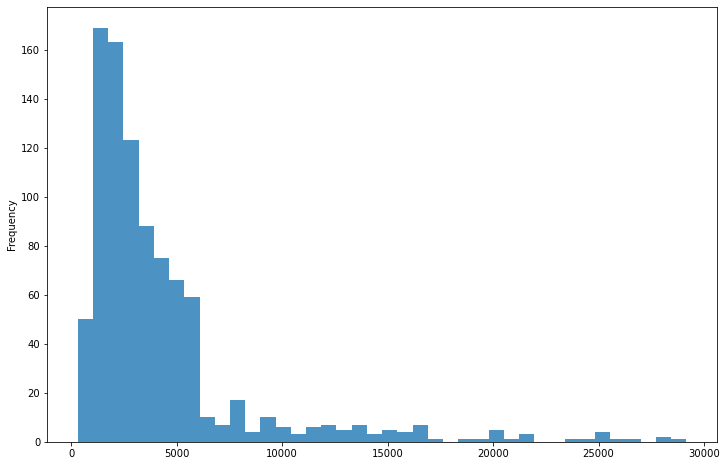

In [166]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=40, alpha=0.8)

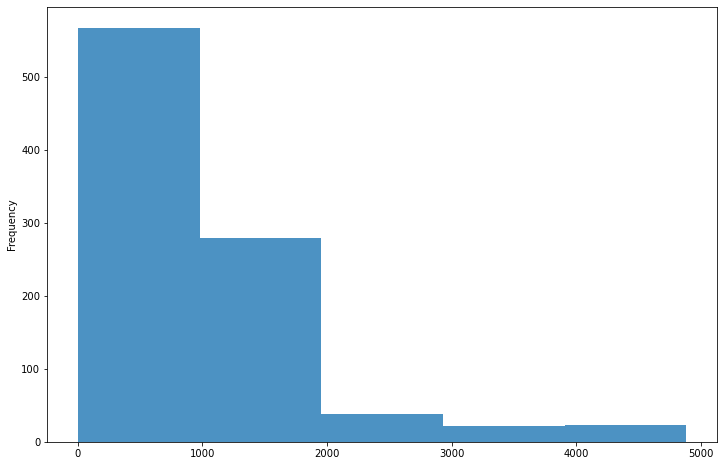

In [167]:
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=5, alpha=0.8)

In [168]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len']>30000:
        print ('excluding', row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 8:
            print ('excluding', row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fbf75c75d05d73d0295fac0 GeneralContract 38360.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2acd9083b679224c77da GeneralContract 49045.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac79083b679224c7750 GeneralContract 41250.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac79083b679224c774f GeneralContract 39315.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac99083b679224c77b0 GeneralContract 39000.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac89083b679224c7786 GeneralContract 43935.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5f9672f182451803b5001df7 GeneralContract 31175.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/60b7a589061c76d77545523c GeneralContract 32720.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2b8da665f7603e03b127c GeneralContract 31095.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7a047c54bc33

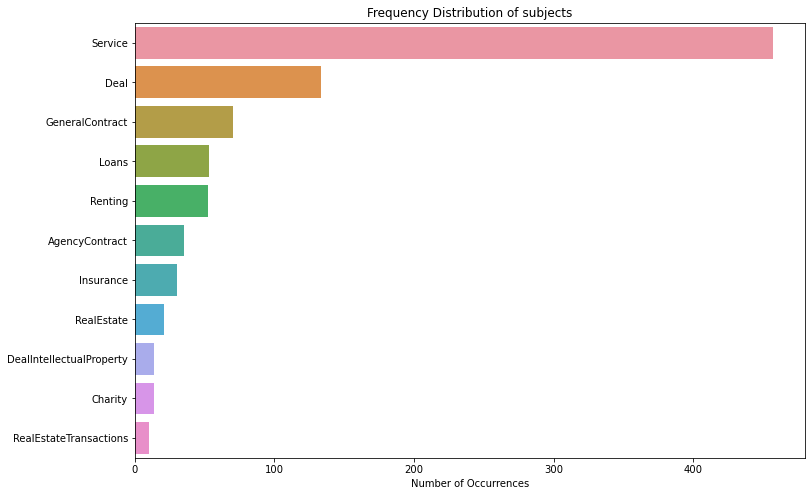

Service                     457
Deal                        133
GeneralContract              70
Loans                        53
Renting                      52
AgencyContract               35
Insurance                    30
RealEstate                   21
DealIntellectualProperty     14
Charity                      14
RealEstateTransactions       10
Name: subject, dtype: int64


In [169]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=cnt.values, y=cnt.index)

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()
print(cnt)

In [170]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 902 - Всего новых документов в обучающем наборе на 2021-10-20 10:13:07.154000

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b127d,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,сбербанк россии,оск,кредитор,проект,Renting,1.394400e+10,2020-09-10 11:10:15.402,2020-09-10 11:10:43.308,...,NaN,23.358315,313.0,True,RUB,12170.0,False,0.685942,-5.607497e+16,1.0
60b7a58e061c76d77545526f,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,газпромбанк,приказодатель,банк,Loans,3.130200e+06,2021-07-31 15:43:37.710,2021-06-05 06:22:34.302,...,NaN,14.956608,186.0,True,EURO,5570.0,False,1.394334,-4.610953e+18,1.0
60b7a4c3061c76d7754545e3,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-аэро,субсубарендатор,субарендатор,Renting,1.080000e+04,2021-07-23 12:29:19.231,2021-06-03 03:28:32.872,...,NaN,9.287394,406.0,True,NaN,2275.0,False,1.725183,3.540390e+18,1.0
60b7a4c3061c76d7754545da,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-ангара,управляемая организация,управляющая организация,Service,5.000000e+04,2021-06-22 13:40:54.455,2021-06-03 03:18:14.469,...,NaN,10.819798,1240.0,True,NaN,2105.0,False,1.904743,7.104948e+17,1.0
60002adfb08473039387bcae,http://gpn-audit.nemosoft.ru/#/audit/edit/6000...,2.3.14,газпромнефть-снабжение,газпром нефть,правообладатель,приобретатель,Deal,4.400005e+07,2021-07-20 07:47:49.711,2021-01-14 14:29:31.907,...,NaN,17.599701,430.0,True,NaN,1510.0,False,2.074317,-5.464112e+18,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fdb2141542ce403c92b456c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,2.3.14,рекламно-информационное агентство «город»,шевцова анна викторовна,спонсируемый,спонсор,Deal,NaN,2020-12-18 09:27:20.264,2020-12-18 12:27:26.400,...,NaN,NaN,NaN,True,NaN,2380.0,False,4691.550133,6.463001e+18,1.0
60b7a522061c76d775454d42,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,паршин сергей владимирович,заказчик,NaN,Service,1.800000e+05,NaT,2021-06-04 12:15:50.881,...,NaN,12.100718,1446.0,True,RUB,3790.0,True,4758.373834,5.356647e+17,1.0
5fc7a034c54bc33809e261ce,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,газпромнефть-снабжение,принципал,агент,AgencyContract,NaN,2020-12-19 14:27:41.953,2020-12-19 17:28:11.494,...,NaN,NaN,NaN,True,NaN,2255.0,False,4793.712945,-6.659146e+18,1.0


In [171]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [172]:
dups_s[dups_s['unseen']]

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
60b7a4c2061c76d7754545ba,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-снабжение,газпромнефть-каталитические системы,поверенный,доверитель,Service,1.000000e+04,NaT,2021-06-03 03:00:53.937,...,NaN,9.210440,1361.0,True,RUB,1995.0,True,35.464518,6.302576e+18,1.0
60b7a4c1061c76d775454594,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,мобильные телесистемы,газпромнефть-каталитические системы,мтс,абонент,Service,5.601250e+04,NaT,2021-06-03 02:26:09.061,...,NaN,10.933348,2742.0,True,RUB,13430.0,True,52.917536,5.808940e+18,1.0
5fca2aab9083b679224c75e1,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,газпром нефть (пао газпром нефть,заемщик»,займодавец,Loans,1.000000e+09,NaT,2020-12-04 12:38:38.017,...,NaN,20.723266,182.0,True,RUB,1345.0,True,53.188749,-6.160472e+18,1.0
5fb399dd39d5e82e9081847d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,газпромнефть-заполярье,газпром добыча оренбург,субарендатор,субарендодатель,Deal,1.859225e+05,NaT,2020-11-17 10:06:27.310,...,NaN,12.133091,472.0,True,RUB,3295.0,True,54.054699,2.970355e+18,1.0
60b7a4f4061c76d7754549bd,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,страховое общество газовой промышленности,газпромнефть-каталитические системы,страховщик,страхователь,Insurance,2.809844e+10,NaT,2021-06-03 22:30:38.761,...,NaN,24.058980,1247.0,True,RUB,13690.0,True,55.238964,7.001681e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb3d4a078df3635f5441c63,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,рекламно-информационное агентство «город»,NaN,исполнитель,заказчик,Service,8.350000e+04,NaT,2020-11-17 14:56:24.561,...,NaN,11.332614,362.0,True,RUB,4425.0,True,4357.468355,1.578973e+18,1.0
5fb3d4a078df3635f5441c49,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,рекламно-информационное агентство «город»,NaN,исполнитель,исполнитель,Service,1.290000e+05,NaT,2020-11-17 14:41:20.587,...,NaN,11.767575,1204.0,True,RUB,3045.0,True,4395.777848,4.015816e+18,1.0
5fb27c60d8c9df1ed1236ec3,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,2.3.14,арктика медиа,NaN,исполнитель,заказчик,Service,5.833333e+04,NaT,2020-11-16 16:50:35.997,...,NaN,10.973946,363.0,True,RUB,4195.0,True,4499.886018,-1.600708e+18,2.0


# Make datapoints

In [173]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    np.save(_dp_fn(id_, 'embeddings'), embeddings)

In [179]:
for k, oid in enumerate(dups_s.index[570:]):
    print(k, oid)
    d = get_doc_by_id( ObjectId(oid))
    jd = DbJsonDoc(d)
    save_contract_data_arrays(jd)


0 5fe48219b770574a0055560a


DEBUG:gpn:skipping embedding doc c2eff4876966476ba28916eb49d6f184 ...., /Users/artem/work/nemo/work/datasets/cache-c2eff4876966476ba28916eb49d6f184-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1665, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a0055560a chs=c2eff4876966476ba28916eb49d6f184
DEBUG:gpn:skipping embedding doc 23a30eb9fbcb89d822b131a4417a34f2 ...., /Users/artem/work/nemo/work/datasets/cache-23a30eb9fbcb89d822b131a4417a34f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e58 chs=23a30eb9fbcb89d822b131a4417a34f2


1 5fb3d7a778df3635f5441e58
2 5fb6750a33c72547b75500f9


DEBUG:gpn:skipping embedding doc 3afd6a595217fd4b81586854c464d0b1 ...., /Users/artem/work/nemo/work/datasets/cache-3afd6a595217fd4b81586854c464d0b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3005, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750a33c72547b75500f9 chs=3afd6a595217fd4b81586854c464d0b1


3 60b7a548061c76d775454f49


DEBUG:gpn:skipping embedding doc 73d6efbfa9258b64b3b1e42da68af3b8 ...., /Users/artem/work/nemo/work/datasets/cache-73d6efbfa9258b64b3b1e42da68af3b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10328, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a548061c76d775454f49 chs=73d6efbfa9258b64b3b1e42da68af3b8


4 60b7a539061c76d775454e56


DEBUG:gpn:skipping embedding doc 9d5e5b6bec5925fcb8ae175e05b7e9eb ...., /Users/artem/work/nemo/work/datasets/cache-9d5e5b6bec5925fcb8ae175e05b7e9eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10468, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a539061c76d775454e56 chs=9d5e5b6bec5925fcb8ae175e05b7e9eb


5 60b7a501061c76d775454ab4


DEBUG:gpn:skipping embedding doc 7b1b58171d4abbc368c1ffa2233b3eab ...., /Users/artem/work/nemo/work/datasets/cache-7b1b58171d4abbc368c1ffa2233b3eab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10461, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a501061c76d775454ab4 chs=7b1b58171d4abbc368c1ffa2233b3eab


6 60b7a4dc061c76d775454815


DEBUG:gpn:skipping embedding doc 830698c870ac9139edcbaf61d9e1482b ...., /Users/artem/work/nemo/work/datasets/cache-830698c870ac9139edcbaf61d9e1482b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9592, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4dc061c76d775454815 chs=830698c870ac9139edcbaf61d9e1482b


7 60b7a532061c76d775454e2f


DEBUG:gpn:skipping embedding doc 91c656f1121e92faf39434d1cd4dd24f ...., /Users/artem/work/nemo/work/datasets/cache-91c656f1121e92faf39434d1cd4dd24f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10320, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a532061c76d775454e2f chs=91c656f1121e92faf39434d1cd4dd24f


8 60b7a546061c76d775454f29


DEBUG:gpn:skipping embedding doc 6e0e210401d1c67017264f33b9f82e7f ...., /Users/artem/work/nemo/work/datasets/cache-6e0e210401d1c67017264f33b9f82e7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14930, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a546061c76d775454f29 chs=6e0e210401d1c67017264f33b9f82e7f


9 60b7a4f6061c76d7754549e0


DEBUG:gpn:skipping embedding doc 5076122740aaf15dea19b50b5c5385a7 ...., /Users/artem/work/nemo/work/datasets/cache-5076122740aaf15dea19b50b5c5385a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7652, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4f6061c76d7754549e0 chs=5076122740aaf15dea19b50b5c5385a7


10 60b7a503061c76d775454ad4


DEBUG:gpn:skipping embedding doc 3d20bc7f3567f4532d45ab9a1fd3a6d3 ...., /Users/artem/work/nemo/work/datasets/cache-3d20bc7f3567f4532d45ab9a1fd3a6d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9301, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a503061c76d775454ad4 chs=3d20bc7f3567f4532d45ab9a1fd3a6d3


11 60b7a597061c76d775455340


DEBUG:gpn:skipping embedding doc a4790340f19a324410d4dd635fc47bb5 ...., /Users/artem/work/nemo/work/datasets/cache-a4790340f19a324410d4dd635fc47bb5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14829, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a597061c76d775455340 chs=a4790340f19a324410d4dd635fc47bb5


12 60b7a53c061c76d775454eb5


DEBUG:gpn:skipping embedding doc 34c267d68308a75788f6e2223c6297c2 ...., /Users/artem/work/nemo/work/datasets/cache-34c267d68308a75788f6e2223c6297c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4833, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53c061c76d775454eb5 chs=34c267d68308a75788f6e2223c6297c2


13 5fb3d49f78df3635f5441c08


DEBUG:gpn:skipping embedding doc 98aea12f164b11d78cbe23beec80c4b3 ...., /Users/artem/work/nemo/work/datasets/cache-98aea12f164b11d78cbe23beec80c4b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3511, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c08 chs=98aea12f164b11d78cbe23beec80c4b3


14 5fb3d7a978df3635f5441ec8


DEBUG:gpn:skipping embedding doc 37ebb766529efa24082d3c28941ef27c ...., /Users/artem/work/nemo/work/datasets/cache-37ebb766529efa24082d3c28941ef27c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4313, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ec8 chs=37ebb766529efa24082d3c28941ef27c


15 5fe4821bb770574a0055567b


DEBUG:gpn:skipping embedding doc cef4bfd28c32c081063ab70b938b6530 ...., /Users/artem/work/nemo/work/datasets/cache-cef4bfd28c32c081063ab70b938b6530-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1892, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055567b chs=cef4bfd28c32c081063ab70b938b6530
DEBUG:gpn:skipping embedding doc 0a401072c6b11ee66f95777493a9e48b ...., /Users/artem/work/nemo/work/datasets/cache-0a401072c6b11ee66f95777493a9e48b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1898, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e59 chs=0a401072c6b11ee66f95777493a9e48b


16 5fb3d7a778df3635f5441e59
17 60b7a526061c76d775454d98


DEBUG:gpn:skipping embedding doc b5fa009d506d29502ab3ae8e0ec9a508 ...., /Users/artem/work/nemo/work/datasets/cache-b5fa009d506d29502ab3ae8e0ec9a508-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3751, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a526061c76d775454d98 chs=b5fa009d506d29502ab3ae8e0ec9a508
DEBUG:gpn:skipping embedding doc 04236b1d6ed57924b85d0ebb75f26a77 ...., /Users/artem/work/nemo/work/datasets/cache-04236b1d6ed57924b85d0ebb75f26a77-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2155, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a527061c76d775454db8 chs=04236b1d6ed57924b85d0ebb75f26a77


18 60b7a527061c76d775454db8
19 60b7a4d4061c76d775454756


DEBUG:gpn:skipping embedding doc d10d8f566e44fc9aefce88dab5ac0574 ...., /Users/artem/work/nemo/work/datasets/cache-d10d8f566e44fc9aefce88dab5ac0574-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2843, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d4061c76d775454756 chs=d10d8f566e44fc9aefce88dab5ac0574
DEBUG:gpn:skipping embedding doc 79f1f84ea6e21c3db5ab7e62003c5875 ...., /Users/artem/work/nemo/work/datasets/cache-79f1f84ea6e21c3db5ab7e62003c5875-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2145, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555631 chs=79f1f84ea6e21c3db5ab7e62003c5875


20 5fe4821ab770574a00555631
21 5fb3d7a478df3635f5441dbd


DEBUG:gpn:skipping embedding doc ddde6f2c776db87e7a274e707eeb565b ...., /Users/artem/work/nemo/work/datasets/cache-ddde6f2c776db87e7a274e707eeb565b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1977, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dbd chs=ddde6f2c776db87e7a274e707eeb565b
DEBUG:gpn:skipping embedding doc 462ea9feba5a8913dc8a2456a6c45480 ...., /Users/artem/work/nemo/work/datasets/cache-462ea9feba5a8913dc8a2456a6c45480-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2445, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a517061c76d775454c6a chs=462ea9feba5a8913dc8a2456a6c45480


22 60b7a517061c76d775454c6a
23 5fb3d7a978df3635f5441ed4


DEBUG:gpn:skipping embedding doc 48c6bd6fc118f07f9d4cdf7938f25549 ...., /Users/artem/work/nemo/work/datasets/cache-48c6bd6fc118f07f9d4cdf7938f25549-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4753, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ed4 chs=48c6bd6fc118f07f9d4cdf7938f25549


24 5fb27c24d8c9df1ed1236e43


DEBUG:gpn:skipping embedding doc 4f4ada710c1d1b6e9772767d31305278 ...., /Users/artem/work/nemo/work/datasets/cache-4f4ada710c1d1b6e9772767d31305278-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9706, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c24d8c9df1ed1236e43 chs=4f4ada710c1d1b6e9772767d31305278


ERROR 2 alias 5fb27c24d8c9df1ed1236e43 'alias' [{'type': {'confidence': 0.7665975689888, 'span': [74, 76], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.6839861869812012, 'span': [76, 80], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.48851001262664795, 'span': [92, 93], 'span_map': 'words', 'value': 'Страхователь'}}, {'type': {'confidence': 0.9998112916946411, 'span': [22, 24], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.782522976398468, 'span': [25, 35], 'span_map': 'words', 'value': 'Страховое общество газовой промышленности" (АО "СОГАЗ"'}}]
25 5fbbbd1ba2b4551c06107a46


DEBUG:gpn:skipping embedding doc 9d68b2a4362ef34420b26b44161c725c ...., /Users/artem/work/nemo/work/datasets/cache-9d68b2a4362ef34420b26b44161c725c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9704, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c06107a46 chs=9d68b2a4362ef34420b26b44161c725c


ERROR 2 alias 5fbbbd1ba2b4551c06107a46 'alias' [{'type': {'confidence': 0.7601575255393982, 'span': [72, 74], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.6905164122581482, 'span': [74, 78], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.4918660819530487, 'span': [90, 91], 'span_map': 'words', 'value': 'Страхователь'}}, {'type': {'confidence': 0.9992380738258362, 'span': [20, 22], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7911956310272217, 'span': [23, 33], 'span_map': 'words', 'value': 'Страховое общество газовой промышленности" (АО "СОГАЗ"'}}]
26 5fe4821fb770574a0055575f


DEBUG:gpn:skipping embedding doc 7f93621eb1b84cf94b1a9044a05b2062 ...., /Users/artem/work/nemo/work/datasets/cache-7f93621eb1b84cf94b1a9044a05b2062-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2724, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055575f chs=7f93621eb1b84cf94b1a9044a05b2062


27 60b7a4d4061c76d775454762


DEBUG:gpn:skipping embedding doc 4580cd80fac3f2741a9559df1814ff49 ...., /Users/artem/work/nemo/work/datasets/cache-4580cd80fac3f2741a9559df1814ff49-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4411, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d4061c76d775454762 chs=4580cd80fac3f2741a9559df1814ff49


28 60b7a4ea061c76d7754548bd


DEBUG:gpn:skipping embedding doc 5aaa1d74afae0061beb0c0acfe4bdc36 ...., /Users/artem/work/nemo/work/datasets/cache-5aaa1d74afae0061beb0c0acfe4bdc36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6355, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548bd chs=5aaa1d74afae0061beb0c0acfe4bdc36


29 60b7a518061c76d775454c78


DEBUG:gpn:skipping embedding doc 3e7227816c312b6c985d00cdef19477b ...., /Users/artem/work/nemo/work/datasets/cache-3e7227816c312b6c985d00cdef19477b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8291, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a518061c76d775454c78 chs=3e7227816c312b6c985d00cdef19477b


30 60b7a4ce061c76d7754546bc


DEBUG:gpn:skipping embedding doc 4dad6b33e174d5c11674ee08ab9dd5a8 ...., /Users/artem/work/nemo/work/datasets/cache-4dad6b33e174d5c11674ee08ab9dd5a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5265, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ce061c76d7754546bc chs=4dad6b33e174d5c11674ee08ab9dd5a8


31 5fb27c62d8c9df1ed1236ef7


DEBUG:gpn:skipping embedding doc 02f29b5355ca0f17397148d43942835d ...., /Users/artem/work/nemo/work/datasets/cache-02f29b5355ca0f17397148d43942835d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3722, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236ef7 chs=02f29b5355ca0f17397148d43942835d
DEBUG:gpn:skipping embedding doc 47961bc218d1a75aae309af262181acb ...., /Users/artem/work/nemo/work/datasets/cache-47961bc218d1a75aae309af262181acb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1394, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674ff33c72547b7550012 chs=47961bc218d1a75aae309af262181acb


32 5fb674ff33c72547b7550012
33 5fbbbd1aa2b4551c061079e1


DEBUG:gpn:skipping embedding doc d65b2e27c214f72bcddf8272334032cf ...., /Users/artem/work/nemo/work/datasets/cache-d65b2e27c214f72bcddf8272334032cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1395, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079e1 chs=d65b2e27c214f72bcddf8272334032cf


34 5fbbe46da2b4551c06107c6c


DEBUG:gpn:skipping embedding doc 90c40a71d75cab34e65cb07b57b4e065 ...., /Users/artem/work/nemo/work/datasets/cache-90c40a71d75cab34e65cb07b57b4e065-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4520, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c6c chs=90c40a71d75cab34e65cb07b57b4e065


35 60b7a516061c76d775454c3f


DEBUG:gpn:skipping embedding doc 73345a53e9cbae572664877a3d7a2cfc ...., /Users/artem/work/nemo/work/datasets/cache-73345a53e9cbae572664877a3d7a2cfc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4206, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a516061c76d775454c3f chs=73345a53e9cbae572664877a3d7a2cfc


36 60b7a593061c76d7754552d7


DEBUG:gpn:skipping embedding doc 8663646c02c12f023b4e931f68b29a7a ...., /Users/artem/work/nemo/work/datasets/cache-8663646c02c12f023b4e931f68b29a7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5263, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a593061c76d7754552d7 chs=8663646c02c12f023b4e931f68b29a7a


37 60b7a531061c76d775454e18


DEBUG:gpn:skipping embedding doc fc284a21e4e0498275288c2106e7a8bc ...., /Users/artem/work/nemo/work/datasets/cache-fc284a21e4e0498275288c2106e7a8bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3791, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a531061c76d775454e18 chs=fc284a21e4e0498275288c2106e7a8bc


38 60b7a4ce061c76d7754546c9


DEBUG:gpn:skipping embedding doc d14370f84e0adaecea88ff35f3948558 ...., /Users/artem/work/nemo/work/datasets/cache-d14370f84e0adaecea88ff35f3948558-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5957, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ce061c76d7754546c9 chs=d14370f84e0adaecea88ff35f3948558


39 60b7a4c6061c76d77545462f


DEBUG:gpn:skipping embedding doc 82549bc536376cd1b04958e2de47e2f2 ...., /Users/artem/work/nemo/work/datasets/cache-82549bc536376cd1b04958e2de47e2f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2539, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c6061c76d77545462f chs=82549bc536376cd1b04958e2de47e2f2


40 5fe48221b770574a005557bf


DEBUG:gpn:skipping embedding doc 5e143fda26b6b0309e2a6f4309fe9843 ...., /Users/artem/work/nemo/work/datasets/cache-5e143fda26b6b0309e2a6f4309fe9843-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2701, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557bf chs=5e143fda26b6b0309e2a6f4309fe9843


41 60b7a4d0061c76d7754546e8


DEBUG:gpn:skipping embedding doc 9bf415352e6efd920c8e9d6701d0cee6 ...., /Users/artem/work/nemo/work/datasets/cache-9bf415352e6efd920c8e9d6701d0cee6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4870, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d0061c76d7754546e8 chs=9bf415352e6efd920c8e9d6701d0cee6


42 60b7a594061c76d7754552ee


DEBUG:gpn:skipping embedding doc fa0a0723be0a896033f0532421ef6be9 ...., /Users/artem/work/nemo/work/datasets/cache-fa0a0723be0a896033f0532421ef6be9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4869, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a594061c76d7754552ee chs=fa0a0723be0a896033f0532421ef6be9
DEBUG:gpn:skipping embedding doc 36ab8651aa90c538d061d0ef5673fa3f ...., /Users/artem/work/nemo/work/datasets/cache-36ab8651aa90c538d061d0ef5673fa3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (763, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed123726a chs=36ab8651aa90c538d061d0ef5673fa3f


43 5fb376e2d8c9df1ed123726a
44 60b7a50b061c76d775454b79


DEBUG:gpn:skipping embedding doc 62fb2665cca2c3abc34a301cdc8d0d9b ...., /Users/artem/work/nemo/work/datasets/cache-62fb2665cca2c3abc34a301cdc8d0d9b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5977, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a50b061c76d775454b79 chs=62fb2665cca2c3abc34a301cdc8d0d9b


45 60b7a599061c76d775455357


DEBUG:gpn:skipping embedding doc 8748ef9ca5f723dfa62d8284fcaa68d8 ...., /Users/artem/work/nemo/work/datasets/cache-8748ef9ca5f723dfa62d8284fcaa68d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3375, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a599061c76d775455357 chs=8748ef9ca5f723dfa62d8284fcaa68d8


46 60b7a4ec061c76d775454904


DEBUG:gpn:skipping embedding doc b9dccc341cdc841e32e9828719555edd ...., /Users/artem/work/nemo/work/datasets/cache-b9dccc341cdc841e32e9828719555edd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5995, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ec061c76d775454904 chs=b9dccc341cdc841e32e9828719555edd
DEBUG:gpn:skipping embedding doc d46d30184fb16f56b8a64d7fba3505ea ...., /Users/artem/work/nemo/work/datasets/cache-d46d30184fb16f56b8a64d7fba3505ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2097, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b03 chs=d46d30184fb16f56b8a64d7fba3505ea


47 5fbbe467a2b4551c06107b03
48 60b7a4d2061c76d775454715


DEBUG:gpn:skipping embedding doc 6fac88af3cc8300c8326cc7435d25941 ...., /Users/artem/work/nemo/work/datasets/cache-6fac88af3cc8300c8326cc7435d25941-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5713, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d2061c76d775454715 chs=6fac88af3cc8300c8326cc7435d25941


49 60b7a598061c76d775455353


DEBUG:gpn:skipping embedding doc 2d2d614c4cb183d3e163efdf8024c257 ...., /Users/artem/work/nemo/work/datasets/cache-2d2d614c4cb183d3e163efdf8024c257-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2985, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a598061c76d775455353 chs=2d2d614c4cb183d3e163efdf8024c257


50 5fe48220b770574a00555772


DEBUG:gpn:skipping embedding doc 7d45bf580e672f2faef3973f161a2cdc ...., /Users/artem/work/nemo/work/datasets/cache-7d45bf580e672f2faef3973f161a2cdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2124, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555772 chs=7d45bf580e672f2faef3973f161a2cdc


51 60b7a53b061c76d775454e92


DEBUG:gpn:skipping embedding doc c0af0920d5f588f3f0c2d65b4f880ea6 ...., /Users/artem/work/nemo/work/datasets/cache-c0af0920d5f588f3f0c2d65b4f880ea6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7793, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53b061c76d775454e92 chs=c0af0920d5f588f3f0c2d65b4f880ea6
DEBUG:gpn:skipping embedding doc a935fe307c9b3084200ac421608f6907 ...., /Users/artem/work/nemo/work/datasets/cache-a935fe307c9b3084200ac421608f6907-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2097, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bc6 chs=a935fe307c9b3084200ac421608f6907


52 5fb3d49e78df3635f5441bc6
53 5fdb2142542ce403c92b4582


DEBUG:gpn:skipping embedding doc 51d062f187fff9b3b9880944e41bcd1c ...., /Users/artem/work/nemo/work/datasets/cache-51d062f187fff9b3b9880944e41bcd1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2952, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4582 chs=51d062f187fff9b3b9880944e41bcd1c


54 60b7a591061c76d7754552a1


DEBUG:gpn:skipping embedding doc 0194c68ec91cce8afcc82e649acec834 ...., /Users/artem/work/nemo/work/datasets/cache-0194c68ec91cce8afcc82e649acec834-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7092, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a591061c76d7754552a1 chs=0194c68ec91cce8afcc82e649acec834


55 60b7a53b061c76d775454e97


DEBUG:gpn:skipping embedding doc 32b88a4ee313362787d7288cfe65f858 ...., /Users/artem/work/nemo/work/datasets/cache-32b88a4ee313362787d7288cfe65f858-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3640, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53b061c76d775454e97 chs=32b88a4ee313362787d7288cfe65f858


56 60b7a5b2061c76d77545552e


DEBUG:gpn:skipping embedding doc 4fb8cd77c9c115ac1d7ec93d8f46e909 ...., /Users/artem/work/nemo/work/datasets/cache-4fb8cd77c9c115ac1d7ec93d8f46e909-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5915, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b2061c76d77545552e chs=4fb8cd77c9c115ac1d7ec93d8f46e909


57 5fbbe46ca2b4551c06107bff


DEBUG:gpn:skipping embedding doc 06ad5b1de5a9b5426f7e0b9ce1d15511 ...., /Users/artem/work/nemo/work/datasets/cache-06ad5b1de5a9b5426f7e0b9ce1d15511-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3006, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107bff chs=06ad5b1de5a9b5426f7e0b9ce1d15511
DEBUG:gpn:skipping embedding doc 79535ba7131cedaaf679e077ef1f1ea0 ...., /Users/artem/work/nemo/work/datasets/cache-79535ba7131cedaaf679e077ef1f1ea0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db8 chs=79535ba7131cedaaf679e077ef1f1ea0


58 5fb3d7a478df3635f5441db8
59 60b7a4d0061c76d7754546f6


DEBUG:gpn:skipping embedding doc e474bdff80ce381698f71e6a9ebe8844 ...., /Users/artem/work/nemo/work/datasets/cache-e474bdff80ce381698f71e6a9ebe8844-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5131, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d0061c76d7754546f6 chs=e474bdff80ce381698f71e6a9ebe8844


60 5fb3d7a678df3635f5441e13


DEBUG:gpn:skipping embedding doc ece72a9fe5126951a7e418bff2fdc153 ...., /Users/artem/work/nemo/work/datasets/cache-ece72a9fe5126951a7e418bff2fdc153-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3794, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e13 chs=ece72a9fe5126951a7e418bff2fdc153
DEBUG:gpn:skipping embedding doc 55664b9c5394415db83459eca5508a26 ...., /Users/artem/work/nemo/work/datasets/cache-55664b9c5394415db83459eca5508a26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2468, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d8 chs=55664b9c5394415db83459eca5508a26


61 5fdb2144542ce403c92b45d8
62 60b7a59a061c76d775455379


DEBUG:gpn:skipping embedding doc d226b2955fe3888bbecf5008843bc002 ...., /Users/artem/work/nemo/work/datasets/cache-d226b2955fe3888bbecf5008843bc002-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4551, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a59a061c76d775455379 chs=d226b2955fe3888bbecf5008843bc002


ERROR 2 type 60b7a59a061c76d775455379 'type' [{'type': {'confidence': 0.9717519879341125, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [36, 40], 'span_map': 'words'}, 'name': {'confidence': 0.8076357245445251, 'kind': 'org-1-name', 'value': 'Информационно-правовая компания «ПРОМЭКС-Инфо»', 'span': [41, 47], 'span_map': 'words'}, 'alias': {'confidence': 0.8284409046173096, 'kind': 'org-1-alias', 'value': 'Исполнитель', 'span': [63, 64], 'span_map': 'words'}}, {'name': {'confidence': 0.5462570786476135, 'kind': 'org-2-name', 'value': 'Газпромнефть-КС', 'span': [85, 86], 'span_map': 'words'}, 'alias': {'confidence': 0.8093724250793457, 'kind': 'org-2-alias', 'value': 'Заказчик', 'span': [92, 93], 'span_map': 'words'}}]
63 5fb3d79c78df3635f5441cfa


DEBUG:gpn:skipping embedding doc 150f6fe3160afb797d087f782434bc09 ...., /Users/artem/work/nemo/work/datasets/cache-150f6fe3160afb797d087f782434bc09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3192, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cfa chs=150f6fe3160afb797d087f782434bc09
DEBUG:gpn:skipping embedding doc be0a80622be86f8abe31be19f478b2f4 ...., /Users/artem/work/nemo/work/datasets/cache-be0a80622be86f8abe31be19f478b2f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1726, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c4061c76d7754545f4 chs=be0a80622be86f8abe31be19f478b2f4


64 60b7a4c4061c76d7754545f4
65 60b7a546061c76d775454f1d


DEBUG:gpn:skipping embedding doc 3aa9ad0ec9f239e3c6374656cbca3ef3 ...., /Users/artem/work/nemo/work/datasets/cache-3aa9ad0ec9f239e3c6374656cbca3ef3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7232, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a546061c76d775454f1d chs=3aa9ad0ec9f239e3c6374656cbca3ef3


66 5fb3d4a178df3635f5441c6f


DEBUG:gpn:skipping embedding doc 18c7fcb9354f9f8696aa96aadd89d7a3 ...., /Users/artem/work/nemo/work/datasets/cache-18c7fcb9354f9f8696aa96aadd89d7a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2456, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c6f chs=18c7fcb9354f9f8696aa96aadd89d7a3


67 60b7a592061c76d7754552b8


DEBUG:gpn:skipping embedding doc e4b49842af569ac12560bdbf887f305a ...., /Users/artem/work/nemo/work/datasets/cache-e4b49842af569ac12560bdbf887f305a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5265, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a592061c76d7754552b8 chs=e4b49842af569ac12560bdbf887f305a


68 5fb6750733c72547b75500a2


DEBUG:gpn:skipping embedding doc 4e4e26ac79445748e93ce314326b868d ...., /Users/artem/work/nemo/work/datasets/cache-4e4e26ac79445748e93ce314326b868d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3018, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500a2 chs=4e4e26ac79445748e93ce314326b868d


69 60b7a59a061c76d77545537e


DEBUG:gpn:skipping embedding doc d69cacab4a9915587540647d6601a949 ...., /Users/artem/work/nemo/work/datasets/cache-d69cacab4a9915587540647d6601a949-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4017, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a59a061c76d77545537e chs=d69cacab4a9915587540647d6601a949


ERROR 2 type 60b7a59a061c76d77545537e 'type' [{'type': {'confidence': 0.9744340777397156, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [191, 195], 'span_map': 'words'}, 'name': {'confidence': 0.9827978610992432, 'kind': 'org-1-name', 'value': 'Информационно-правовая компания «ПРОМЭКС-Инфо»', 'span': [196, 202], 'span_map': 'words'}, 'alias': {'confidence': 0.7351111769676208, 'kind': 'org-1-alias', 'value': 'Исполнитель', 'span': [223, 224], 'span_map': 'words'}}, {'name': {'confidence': 0.4415057301521301, 'kind': 'org-2-name', 'value': 'Газпромнефть-КС', 'span': [245, 247], 'span_map': 'words'}, 'alias': {'confidence': 0.8652775883674622, 'kind': 'org-2-alias', 'value': 'Заказчик', 'span': [253, 254], 'span_map': 'words'}}]
70 5fb674f633c72547b754ff54


DEBUG:gpn:skipping embedding doc 69f2b73f66e8e71f9f773c11c3e8efa9 ...., /Users/artem/work/nemo/work/datasets/cache-69f2b73f66e8e71f9f773c11c3e8efa9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1806, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f633c72547b754ff54 chs=69f2b73f66e8e71f9f773c11c3e8efa9


71 60b7a531061c76d775454e12


DEBUG:gpn:skipping embedding doc cd5b5f760d695dc86b693476270755be ...., /Users/artem/work/nemo/work/datasets/cache-cd5b5f760d695dc86b693476270755be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3854, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a531061c76d775454e12 chs=cd5b5f760d695dc86b693476270755be


72 60b7a592061c76d7754552c9


DEBUG:gpn:skipping embedding doc de148f9ac6538a563b24872d5b40ab98 ...., /Users/artem/work/nemo/work/datasets/cache-de148f9ac6538a563b24872d5b40ab98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5201, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a592061c76d7754552c9 chs=de148f9ac6538a563b24872d5b40ab98


73 60b7a532061c76d775454e35


DEBUG:gpn:skipping embedding doc 66d8012822297e75561a57fb062e1a0a ...., /Users/artem/work/nemo/work/datasets/cache-66d8012822297e75561a57fb062e1a0a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5002, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a532061c76d775454e35 chs=66d8012822297e75561a57fb062e1a0a


74 60b7a594061c76d7754552e8


DEBUG:gpn:skipping embedding doc c90c436d34f0df3a043ec69deb749e56 ...., /Users/artem/work/nemo/work/datasets/cache-c90c436d34f0df3a043ec69deb749e56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5136, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a594061c76d7754552e8 chs=c90c436d34f0df3a043ec69deb749e56
DEBUG:gpn:skipping embedding doc 55095b0c3aeec93b193d3a4b75f12524 ...., /Users/artem/work/nemo/work/datasets/cache-55095b0c3aeec93b193d3a4b75f12524-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1332, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b4519 chs=55095b0c3aeec93b193d3a4b75f12524


75 5fdb213d542ce403c92b4519
76 5fb3d7a978df3635f5441ebb


DEBUG:gpn:skipping embedding doc 1c00f134b946705b7460db3fa154b24f ...., /Users/artem/work/nemo/work/datasets/cache-1c00f134b946705b7460db3fa154b24f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4910, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ebb chs=1c00f134b946705b7460db3fa154b24f


77 5fb3d7a978df3635f5441eb5


DEBUG:gpn:skipping embedding doc 1cb5b9253b29c2ec8e49f0a675547e82 ...., /Users/artem/work/nemo/work/datasets/cache-1cb5b9253b29c2ec8e49f0a675547e82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5747, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441eb5 chs=1cb5b9253b29c2ec8e49f0a675547e82


78 60b7a522061c76d775454d2d


DEBUG:gpn:skipping embedding doc c18c6c9dedc02f12ea5a7f782cf725d7 ...., /Users/artem/work/nemo/work/datasets/cache-c18c6c9dedc02f12ea5a7f782cf725d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3021, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a522061c76d775454d2d chs=c18c6c9dedc02f12ea5a7f782cf725d7


79 60b7a501061c76d775454ab7


DEBUG:gpn:skipping embedding doc 2dd0b34adc19fba5522e1a14f4f0abc3 ...., /Users/artem/work/nemo/work/datasets/cache-2dd0b34adc19fba5522e1a14f4f0abc3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6069, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a501061c76d775454ab7 chs=2dd0b34adc19fba5522e1a14f4f0abc3


80 60b7a4ff061c76d775454a19


DEBUG:gpn:skipping embedding doc d4ac6716b18d15f9d528fb625f3c08fc ...., /Users/artem/work/nemo/work/datasets/cache-d4ac6716b18d15f9d528fb625f3c08fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13383, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ff061c76d775454a19 chs=d4ac6716b18d15f9d528fb625f3c08fc


81 60b7a595061c76d7754552fc


DEBUG:gpn:skipping embedding doc 335bd4be82ecbc0f8891c9ff3a66ad56 ...., /Users/artem/work/nemo/work/datasets/cache-335bd4be82ecbc0f8891c9ff3a66ad56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5023, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a595061c76d7754552fc chs=335bd4be82ecbc0f8891c9ff3a66ad56


82 60b7a4d1061c76d7754546fe


DEBUG:gpn:skipping embedding doc ecaec4d20a6dfe79d2e850472d4205f2 ...., /Users/artem/work/nemo/work/datasets/cache-ecaec4d20a6dfe79d2e850472d4205f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6046, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d1061c76d7754546fe chs=ecaec4d20a6dfe79d2e850472d4205f2


83 60b7a507061c76d775454b04


DEBUG:gpn:skipping embedding doc 6a52ef0808c497f4b89309a851290975 ...., /Users/artem/work/nemo/work/datasets/cache-6a52ef0808c497f4b89309a851290975-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2825, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a507061c76d775454b04 chs=6a52ef0808c497f4b89309a851290975
DEBUG:gpn:skipping embedding doc 6c42fa60e3cb7087f5ffc4dfb5f6f592 ...., /Users/artem/work/nemo/work/datasets/cache-6c42fa60e3cb7087f5ffc4dfb5f6f592-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1732, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a506061c76d775454afb chs=6c42fa60e3cb7087f5ffc4dfb5f6f592


84 60b7a506061c76d775454afb
85 5fb3d4a178df3635f5441c7e


DEBUG:gpn:skipping embedding doc 39cf5df1e67eceae3cadfefd42a8fd5a ...., /Users/artem/work/nemo/work/datasets/cache-39cf5df1e67eceae3cadfefd42a8fd5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3016, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c7e chs=39cf5df1e67eceae3cadfefd42a8fd5a


86 5fbbe46ea2b4551c06107c9e


DEBUG:gpn:skipping embedding doc e5c4477bb27fdffef9ab3b13fa94f8e5 ...., /Users/artem/work/nemo/work/datasets/cache-e5c4477bb27fdffef9ab3b13fa94f8e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11732, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ea2b4551c06107c9e chs=e5c4477bb27fdffef9ab3b13fa94f8e5
DEBUG:gpn:skipping embedding doc e8a64a887a33710c7584c10b5f9d0593 ...., /Users/artem/work/nemo/work/datasets/cache-e8a64a887a33710c7584c10b5f9d0593-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1362, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfc chs=e8a64a887a33710c7584c10b5f9d0593


ERROR 2 alias 5fbbe46ea2b4551c06107c9e 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [56, 58], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [59, 61], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [74, 75], 'span_map': 'words', 'value': 'Страхователь'}}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [25, 28], 'span_map': 'words', 'value': 'СОГАЗ'}, 'type': {'confidence': 1, 'kind': 'org-2-type', 'key': 'org-2-type', 'span': [21, 23], 'span_map': 'words', 'value': 'Акционерное общество', 'changed': True, 'parent': ''}}]
87 5fb3d49f78df3635f5441bfc
88 60b7a4eb061c76d7754548de


DEBUG:gpn:skipping embedding doc c4dfcbdee0d61102d61abe622f58b4c8 ...., /Users/artem/work/nemo/work/datasets/cache-c4dfcbdee0d61102d61abe622f58b4c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1081, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4eb061c76d7754548de chs=c4dfcbdee0d61102d61abe622f58b4c8


89 60b7a53b061c76d775454e9f


DEBUG:gpn:skipping embedding doc c834083be96180beadf05c46bcf94d74 ...., /Users/artem/work/nemo/work/datasets/cache-c834083be96180beadf05c46bcf94d74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7794, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53b061c76d775454e9f chs=c834083be96180beadf05c46bcf94d74


90 5fe48221b770574a005557c7


DEBUG:gpn:skipping embedding doc 6b9c54c0807d200748c99700da444d6f ...., /Users/artem/work/nemo/work/datasets/cache-6b9c54c0807d200748c99700da444d6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3125, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557c7 chs=6b9c54c0807d200748c99700da444d6f
DEBUG:gpn:skipping embedding doc 658f4094aaa227795674fdabda7ae4d8 ...., /Users/artem/work/nemo/work/datasets/cache-658f4094aaa227795674fdabda7ae4d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1171, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e9061c76d7754548ba chs=658f4094aaa227795674fdabda7ae4d8


91 60b7a4e9061c76d7754548ba
92 60b7a4eb061c76d7754548e4


DEBUG:gpn:skipping embedding doc e67f164cca745daf0cee4d778e1f0a1d ...., /Users/artem/work/nemo/work/datasets/cache-e67f164cca745daf0cee4d778e1f0a1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (953, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4eb061c76d7754548e4 chs=e67f164cca745daf0cee4d778e1f0a1d


93 5fb376e4d8c9df1ed12372a1


DEBUG:gpn:skipping embedding doc ca824fd3d355b36ab07699921cf1f18b ...., /Users/artem/work/nemo/work/datasets/cache-ca824fd3d355b36ab07699921cf1f18b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2507, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e4d8c9df1ed12372a1 chs=ca824fd3d355b36ab07699921cf1f18b


94 60b7a4c1061c76d7754545a7


DEBUG:gpn:skipping embedding doc 183a1ece2b62cce9e4bca4b673c0abad ...., /Users/artem/work/nemo/work/datasets/cache-183a1ece2b62cce9e4bca4b673c0abad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2639, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c1061c76d7754545a7 chs=183a1ece2b62cce9e4bca4b673c0abad
DEBUG:gpn:skipping embedding doc 86bb34bd9312c87429efcc87ef17a7b6 ...., /Users/artem/work/nemo/work/datasets/cache-86bb34bd9312c87429efcc87ef17a7b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1835, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d94 chs=86bb34bd9312c87429efcc87ef17a7b6


95 5fb3d7a378df3635f5441d94
96 5ec2b8da665f7603e03b1255


DEBUG:gpn:skipping embedding doc 3187bfac60ea578221c5d9357756c6c1 ...., /Users/artem/work/nemo/work/datasets/cache-3187bfac60ea578221c5d9357756c6c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5847, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1255 chs=3187bfac60ea578221c5d9357756c6c1


ERROR 2 name 5ec2b8da665f7603e03b1255 list index out of range [{'type': {'confidence': 0.9935, 'span': [13, 17], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.991, 'span': [18, 21], 'span_map': 'words', 'value': 'Газпромнефть научно-технический центр'}, 'alias': {'confidence': 0.984, 'span': [32, 33], 'span_map': 'words', 'value': 'ГПН'}, 'alt_name': {'confidence': 0.989, 'span': [22, 28], 'span_map': 'words', 'value': '(ООО «ЦТН»)'}}]
ERROR 2 alias 5ec2b8da665f7603e03b1255 list index out of range [{'type': {'confidence': 0.9935, 'span': [13, 17], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.991, 'span': [18, 21], 'span_map': 'words', 'value': 'Газпромнефть научно-технический центр'}, 'alias': {'confidence': 0.984, 'span': [32, 33], 'span_map': 'words', 'value': 'ГПН'}, 'alt_name': {'confidence': 0.989, 'span': [22, 28], 'span_map': 'words', 'value': '(ООО «ЦТН»)'}}]
ERROR 2 typ

DEBUG:gpn:skipping embedding doc 6138c12f003b7815cfc2a326b22cecd0 ...., /Users/artem/work/nemo/work/datasets/cache-6138c12f003b7815cfc2a326b22cecd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c70 chs=6138c12f003b7815cfc2a326b22cecd0
DEBUG:gpn:skipping embedding doc 972ab4861fc3e1c40a66eee20653df5b ...., /Users/artem/work/nemo/work/datasets/cache-972ab4861fc3e1c40a66eee20653df5b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2228, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f3 chs=972ab4861fc3e1c40a66eee20653df5b


98 5fdb2145542ce403c92b45f3
99 5fe4821fb770574a00555741


DEBUG:gpn:skipping embedding doc 8dceb00aaefe9c38b75de9d170b212f5 ...., /Users/artem/work/nemo/work/datasets/cache-8dceb00aaefe9c38b75de9d170b212f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2036, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555741 chs=8dceb00aaefe9c38b75de9d170b212f5
DEBUG:gpn:skipping embedding doc 0513de2899138a9c444fa9f6be9825a0 ...., /Users/artem/work/nemo/work/datasets/cache-0513de2899138a9c444fa9f6be9825a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (874, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548d8 chs=0513de2899138a9c444fa9f6be9825a0


100 60b7a4ea061c76d7754548d8
101 60b7a53b061c76d775454ea4


DEBUG:gpn:skipping embedding doc ea6e2e9b55b515456e218e4d7d3e8268 ...., /Users/artem/work/nemo/work/datasets/cache-ea6e2e9b55b515456e218e4d7d3e8268-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3739, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53b061c76d775454ea4 chs=ea6e2e9b55b515456e218e4d7d3e8268
DEBUG:gpn:skipping embedding doc 6ed8a780dd6892162223c4db466e9345 ...., /Users/artem/work/nemo/work/datasets/cache-6ed8a780dd6892162223c4db466e9345-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1894, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e83 chs=6ed8a780dd6892162223c4db466e9345


102 5fb3d7a878df3635f5441e83
103 60b7a4eb061c76d7754548dd


DEBUG:gpn:skipping embedding doc 54398b05dcc19c9d3c61dff9dce14856 ...., /Users/artem/work/nemo/work/datasets/cache-54398b05dcc19c9d3c61dff9dce14856-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4859, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4eb061c76d7754548dd chs=54398b05dcc19c9d3c61dff9dce14856
DEBUG:gpn:skipping embedding doc e91883d22724485a0f74c9961350acfa ...., /Users/artem/work/nemo/work/datasets/cache-e91883d22724485a0f74c9961350acfa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1370, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a599061c76d775455366 chs=e91883d22724485a0f74c9961350acfa
DEBUG:gpn:skipping embedding doc 3456bf3182f29442428e50e621d330d3 ...., /Users/artem/work/nemo/work/datasets/cache-3456bf3182f29442428e50e621d330d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1275, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a505061c76d775454af2

104 60b7a599061c76d775455366
105 60b7a505061c76d775454af2
106 5fdb213f542ce403c92b452f


DEBUG:gpn:skipping embedding doc 0d342279406a5d3197f9e640a5f6f0a1 ...., /Users/artem/work/nemo/work/datasets/cache-0d342279406a5d3197f9e640a5f6f0a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3230, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452f chs=0d342279406a5d3197f9e640a5f6f0a1
DEBUG:gpn:skipping embedding doc 7ace356f9bab2687410eeb507c5ade86 ...., /Users/artem/work/nemo/work/datasets/cache-7ace356f9bab2687410eeb507c5ade86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1583, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a501061c76d775454aa2 chs=7ace356f9bab2687410eeb507c5ade86


107 60b7a501061c76d775454aa2
108 60b7a595061c76d7754552fb


DEBUG:gpn:skipping embedding doc 31fbb2d4e64dad6f820d915fed70989f ...., /Users/artem/work/nemo/work/datasets/cache-31fbb2d4e64dad6f820d915fed70989f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19986, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a595061c76d7754552fb chs=31fbb2d4e64dad6f820d915fed70989f


109 5fbbbd1aa2b4551c061079f9


DEBUG:gpn:skipping embedding doc 1c2955bc10f0e3098369a4f03e50d889 ...., /Users/artem/work/nemo/work/datasets/cache-1c2955bc10f0e3098369a4f03e50d889-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3595, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079f9 chs=1c2955bc10f0e3098369a4f03e50d889


110 5fe4821eb770574a00555705


DEBUG:gpn:skipping embedding doc b0b236e2e91868b04946e44dac872f21 ...., /Users/artem/work/nemo/work/datasets/cache-b0b236e2e91868b04946e44dac872f21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2947, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555705 chs=b0b236e2e91868b04946e44dac872f21


111 60b7a4d1061c76d77545470b


DEBUG:gpn:skipping embedding doc 17f8d3b084d09d457eb15389fcdb0c36 ...., /Users/artem/work/nemo/work/datasets/cache-17f8d3b084d09d457eb15389fcdb0c36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5065, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d1061c76d77545470b chs=17f8d3b084d09d457eb15389fcdb0c36


112 60b7a4d5061c76d775454770


DEBUG:gpn:skipping embedding doc b12619f1430cb5e2c429d592e3be8e48 ...., /Users/artem/work/nemo/work/datasets/cache-b12619f1430cb5e2c429d592e3be8e48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5652, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d5061c76d775454770 chs=b12619f1430cb5e2c429d592e3be8e48


113 60b7a56f061c76d77545517a


DEBUG:gpn:skipping embedding doc 5881829ed3b74906557fa0bde7e2a5a0 ...., /Users/artem/work/nemo/work/datasets/cache-5881829ed3b74906557fa0bde7e2a5a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5661, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a56f061c76d77545517a chs=5881829ed3b74906557fa0bde7e2a5a0


114 60b7a5b3061c76d77545555c


DEBUG:gpn:skipping embedding doc 2be47912794ad837975d719ea46e90a3 ...., /Users/artem/work/nemo/work/datasets/cache-2be47912794ad837975d719ea46e90a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2830, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b3061c76d77545555c chs=2be47912794ad837975d719ea46e90a3


115 60b7a4ea061c76d7754548da


DEBUG:gpn:skipping embedding doc 2c4daebb6cb19c020cd4de84813b1c9f ...., /Users/artem/work/nemo/work/datasets/cache-2c4daebb6cb19c020cd4de84813b1c9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3083, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548da chs=2c4daebb6cb19c020cd4de84813b1c9f


116 60b7a5a7061c76d775455472


DEBUG:gpn:skipping embedding doc 858e2f5491307a45e9c4a6c281e8a34f ...., /Users/artem/work/nemo/work/datasets/cache-858e2f5491307a45e9c4a6c281e8a34f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4804, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a7061c76d775455472 chs=858e2f5491307a45e9c4a6c281e8a34f


117 60b7a599061c76d77545536b


DEBUG:gpn:skipping embedding doc 9cd1774378c876958e191e114dd5d194 ...., /Users/artem/work/nemo/work/datasets/cache-9cd1774378c876958e191e114dd5d194-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4072, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a599061c76d77545536b chs=9cd1774378c876958e191e114dd5d194
DEBUG:gpn:skipping embedding doc 57b42a2b1f9e288e4a10863b00f7a112 ...., /Users/artem/work/nemo/work/datasets/cache-57b42a2b1f9e288e4a10863b00f7a112-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1093, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548d2 chs=57b42a2b1f9e288e4a10863b00f7a112


118 60b7a4ea061c76d7754548d2
119 60b7a50a061c76d775454b6d


DEBUG:gpn:skipping embedding doc dd3c778ed1d8e4d014d847cacbe0ba40 ...., /Users/artem/work/nemo/work/datasets/cache-dd3c778ed1d8e4d014d847cacbe0ba40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5355, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a50a061c76d775454b6d chs=dd3c778ed1d8e4d014d847cacbe0ba40
DEBUG:gpn:skipping embedding doc 060666485ab1983107cdaa51aea29aa8 ...., /Users/artem/work/nemo/work/datasets/cache-060666485ab1983107cdaa51aea29aa8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1800, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79a78df3635f5441cc2 chs=060666485ab1983107cdaa51aea29aa8


120 5fb3d79a78df3635f5441cc2
121 5fe48217b770574a00555581


DEBUG:gpn:skipping embedding doc 2fd69445af511a22793206fbba16b598 ...., /Users/artem/work/nemo/work/datasets/cache-2fd69445af511a22793206fbba16b598-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1797, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555581 chs=2fd69445af511a22793206fbba16b598
DEBUG:gpn:skipping embedding doc 07ce2e4f9d0f2acfd6f5412b78548893 ...., /Users/artem/work/nemo/work/datasets/cache-07ce2e4f9d0f2acfd6f5412b78548893-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1637, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a1061c76d775455401 chs=07ce2e4f9d0f2acfd6f5412b78548893


122 60b7a5a1061c76d775455401
123 60b7a5b3061c76d77545555d


DEBUG:gpn:skipping embedding doc 58fd5021e4bbafe1486e660834c3c853 ...., /Users/artem/work/nemo/work/datasets/cache-58fd5021e4bbafe1486e660834c3c853-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5713, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b3061c76d77545555d chs=58fd5021e4bbafe1486e660834c3c853
DEBUG:gpn:skipping embedding doc 4a1705c349ef304bc5511d7f24c4425f ...., /Users/artem/work/nemo/work/datasets/cache-4a1705c349ef304bc5511d7f24c4425f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c06107932 chs=4a1705c349ef304bc5511d7f24c4425f


124 5fbbbd16a2b4551c06107932
125 5fe4821eb770574a005556e8


DEBUG:gpn:skipping embedding doc 6c369a3a9daadb5581283ba1c2f17391 ...., /Users/artem/work/nemo/work/datasets/cache-6c369a3a9daadb5581283ba1c2f17391-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2229, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556e8 chs=6c369a3a9daadb5581283ba1c2f17391


126 60b7a4eb061c76d7754548e2


DEBUG:gpn:skipping embedding doc df37ca8221dc438eae52cd7d9dddbe51 ...., /Users/artem/work/nemo/work/datasets/cache-df37ca8221dc438eae52cd7d9dddbe51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3321, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4eb061c76d7754548e2 chs=df37ca8221dc438eae52cd7d9dddbe51
DEBUG:gpn:skipping embedding doc d3fb57be904cb466f3df97a631b33337 ...., /Users/artem/work/nemo/work/datasets/cache-d3fb57be904cb466f3df97a631b33337-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548cf chs=d3fb57be904cb466f3df97a631b33337


127 60b7a4ea061c76d7754548cf
128 60b7a50e061c76d775454bb8


DEBUG:gpn:skipping embedding doc 12962fa26495094f8261cf08659a8a2c ...., /Users/artem/work/nemo/work/datasets/cache-12962fa26495094f8261cf08659a8a2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2333, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a50e061c76d775454bb8 chs=12962fa26495094f8261cf08659a8a2c
DEBUG:gpn:skipping embedding doc 084192d3017300bc9ceea08022785327 ...., /Users/artem/work/nemo/work/datasets/cache-084192d3017300bc9ceea08022785327-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1021, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e9061c76d7754548b7 chs=084192d3017300bc9ceea08022785327


129 60b7a4e9061c76d7754548b7
130 5fe4821db770574a005556cc


DEBUG:gpn:skipping embedding doc 7596976055bbd0ad29e4b5d6cb0d5bf2 ...., /Users/artem/work/nemo/work/datasets/cache-7596976055bbd0ad29e4b5d6cb0d5bf2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2426, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556cc chs=7596976055bbd0ad29e4b5d6cb0d5bf2
DEBUG:gpn:skipping embedding doc 70d0f43f283f5aed0a53c33cf299c609 ...., /Users/artem/work/nemo/work/datasets/cache-70d0f43f283f5aed0a53c33cf299c609-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1579, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c5061c76d775454617 chs=70d0f43f283f5aed0a53c33cf299c609


131 60b7a4c5061c76d775454617
132 60b7a4ea061c76d7754548d6


DEBUG:gpn:skipping embedding doc b74bd8986f194eb22e471db7f2088c9c ...., /Users/artem/work/nemo/work/datasets/cache-b74bd8986f194eb22e471db7f2088c9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3100, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548d6 chs=b74bd8986f194eb22e471db7f2088c9c
DEBUG:gpn:skipping embedding doc d93be05a9694bf8282f8477ede7e0dd6 ...., /Users/artem/work/nemo/work/datasets/cache-d93be05a9694bf8282f8477ede7e0dd6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (937, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a515061c76d775454c2b chs=d93be05a9694bf8282f8477ede7e0dd6


133 60b7a515061c76d775454c2b
134 5fb3d49f78df3635f5441bea


DEBUG:gpn:skipping embedding doc 1d559b74454873c126049b3a556e7f0c ...., /Users/artem/work/nemo/work/datasets/cache-1d559b74454873c126049b3a556e7f0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1340, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bea chs=1d559b74454873c126049b3a556e7f0c


135 60b7a502061c76d775454ac1


DEBUG:gpn:skipping embedding doc 319d64604260f7111ac9a0c06f1bffd3 ...., /Users/artem/work/nemo/work/datasets/cache-319d64604260f7111ac9a0c06f1bffd3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6451, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a502061c76d775454ac1 chs=319d64604260f7111ac9a0c06f1bffd3
DEBUG:gpn:skipping embedding doc d79d8f5e3a4a3e5b87e15b43fd5d1076 ...., /Users/artem/work/nemo/work/datasets/cache-d79d8f5e3a4a3e5b87e15b43fd5d1076-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1139, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a523061c76d775454d4b chs=d79d8f5e3a4a3e5b87e15b43fd5d1076


136 60b7a523061c76d775454d4b
137 5fb3d7a378df3635f5441d8e


DEBUG:gpn:skipping embedding doc 6870fe5f049c526db28e0034fcb32917 ...., /Users/artem/work/nemo/work/datasets/cache-6870fe5f049c526db28e0034fcb32917-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2694, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d8e chs=6870fe5f049c526db28e0034fcb32917


138 5fb3d7a478df3635f5441dd1


DEBUG:gpn:skipping embedding doc 2e08c67850980ccc79f7322463d2a9f4 ...., /Users/artem/work/nemo/work/datasets/cache-2e08c67850980ccc79f7322463d2a9f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5572, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dd1 chs=2e08c67850980ccc79f7322463d2a9f4


139 5fb399dd39d5e82e90818477


DEBUG:gpn:skipping embedding doc 44d1c22fb92ce75663dc046c184df359 ...., /Users/artem/work/nemo/work/datasets/cache-44d1c22fb92ce75663dc046c184df359-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5211, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dd39d5e82e90818477 chs=44d1c22fb92ce75663dc046c184df359


ERROR 2 name 5fb399dd39d5e82e90818477 'name' [{'type': {'confidence': 0.9994325041770935, 'span': [59, 63], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.7984113097190857, 'span': [64, 67], 'span_map': 'words', 'value': 'Газпромнефть-Заполярье'}, 'alias': {'confidence': 0.378257691860199, 'span': [81, 82], 'span_map': 'words', 'value': 'Арендатор'}}, {'alias': {'confidence': 0.9858579635620117, 'span': [32, 33], 'span_map': 'words', 'value': 'Арендодатель'}}]
ERROR 2 type 5fb399dd39d5e82e90818477 'type' [{'type': {'confidence': 0.9994325041770935, 'span': [59, 63], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.7984113097190857, 'span': [64, 67], 'span_map': 'words', 'value': 'Газпромнефть-Заполярье'}, 'alias': {'confidence': 0.378257691860199, 'span': [81, 82], 'span_map': 'words', 'value': 'Арендатор'}}, {'alias': {'confidence': 0.9858579635620117, 'span': [32, 33], 'span_map': 

DEBUG:gpn:skipping embedding doc 21b3cefccb16f68f46eab84875555ad9 ...., /Users/artem/work/nemo/work/datasets/cache-21b3cefccb16f68f46eab84875555ad9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4970, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a592061c76d7754552be chs=21b3cefccb16f68f46eab84875555ad9
DEBUG:gpn:skipping embedding doc 058678d59042a661d92decc33562e1ce ...., /Users/artem/work/nemo/work/datasets/cache-058678d59042a661d92decc33562e1ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2362, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4f2061c76d7754549a3 chs=058678d59042a661d92decc33562e1ce


141 60b7a4f2061c76d7754549a3
142 5fb3d7a678df3635f5441e35


DEBUG:gpn:skipping embedding doc 9e8536c0ae0b635b5cce4c0ef1cf357c ...., /Users/artem/work/nemo/work/datasets/cache-9e8536c0ae0b635b5cce4c0ef1cf357c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3736, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e35 chs=9e8536c0ae0b635b5cce4c0ef1cf357c
DEBUG:gpn:skipping embedding doc 06e21e20c6b22528113aa5f1bec93a98 ...., /Users/artem/work/nemo/work/datasets/cache-06e21e20c6b22528113aa5f1bec93a98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1014, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a515061c76d775454c29 chs=06e21e20c6b22528113aa5f1bec93a98


ERROR 2 name 5fb3d7a678df3635f5441e35 'name' [{'type': {'confidence': 0.9850339889526367, 'span': [62, 66], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9744337797164917, 'span': [67, 72], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7293875217437744, 'span': [78, 79], 'span_map': 'words', 'value': 'Поставщик'}}, {'alias': {'confidence': 0.9601885080337524, 'span': [41, 42], 'span_map': 'words', 'value': 'Покупатель'}}]
ERROR 2 type 5fb3d7a678df3635f5441e35 'type' [{'type': {'confidence': 0.9850339889526367, 'span': [62, 66], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9744337797164917, 'span': [67, 72], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7293875217437744, 'span': [78, 79], 'span_map': 'words', 'value': 'Поставщик'}}, {

DEBUG:gpn:skipping embedding doc c563cbe4088d986091791a5786742f87 ...., /Users/artem/work/nemo/work/datasets/cache-c563cbe4088d986091791a5786742f87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1245, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b2061c76d775455542 chs=c563cbe4088d986091791a5786742f87
DEBUG:gpn:skipping embedding doc ffaa7962c2104945049e28414886d7ac ...., /Users/artem/work/nemo/work/datasets/cache-ffaa7962c2104945049e28414886d7ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1367, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bd1 chs=ffaa7962c2104945049e28414886d7ac


145 5fbbe46ba2b4551c06107bd1
146 60b7a515061c76d775454c2d


DEBUG:gpn:skipping embedding doc 73d3e4cb041ca718ff64cbba34b7f955 ...., /Users/artem/work/nemo/work/datasets/cache-73d3e4cb041ca718ff64cbba34b7f955-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1024, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a515061c76d775454c2d chs=73d3e4cb041ca718ff64cbba34b7f955
DEBUG:gpn:skipping embedding doc 59e68c03e4d1088b3c3be4d124198f08 ...., /Users/artem/work/nemo/work/datasets/cache-59e68c03e4d1088b3c3be4d124198f08-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4be061c76d77545454b chs=59e68c03e4d1088b3c3be4d124198f08


147 60b7a4be061c76d77545454b
148 60b7a4e3061c76d77545487b


DEBUG:gpn:skipping embedding doc 492a537c31b8b2bfc3aa36678a6bbba9 ...., /Users/artem/work/nemo/work/datasets/cache-492a537c31b8b2bfc3aa36678a6bbba9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3392, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e3061c76d77545487b chs=492a537c31b8b2bfc3aa36678a6bbba9


149 5fdb2143542ce403c92b45af


DEBUG:gpn:skipping embedding doc 31e8e778496b42dff57ed8a4080a8229 ...., /Users/artem/work/nemo/work/datasets/cache-31e8e778496b42dff57ed8a4080a8229-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3686, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45af chs=31e8e778496b42dff57ed8a4080a8229


150 5fbbbd18a2b4551c0610798d


DEBUG:gpn:skipping embedding doc 9174f3dab9ffc653995770d8728851a2 ...., /Users/artem/work/nemo/work/datasets/cache-9174f3dab9ffc653995770d8728851a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3847, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd18a2b4551c0610798d chs=9174f3dab9ffc653995770d8728851a2


151 5fbbe46aa2b4551c06107bc5


DEBUG:gpn:skipping embedding doc 27be8981a48b6380be1d01a0294095d9 ...., /Users/artem/work/nemo/work/datasets/cache-27be8981a48b6380be1d01a0294095d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bc5 chs=27be8981a48b6380be1d01a0294095d9
DEBUG:gpn:skipping embedding doc 0f0d72d4f3916014d4a4c8c7968f70e3 ...., /Users/artem/work/nemo/work/datasets/cache-0f0d72d4f3916014d4a4c8c7968f70e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1538, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e0d8c9df1ed123724d chs=0f0d72d4f3916014d4a4c8c7968f70e3


152 5fb376e0d8c9df1ed123724d
153 60b7a515061c76d775454c28


DEBUG:gpn:skipping embedding doc 60d135a34e0e574e6a007e3d92c7cea8 ...., /Users/artem/work/nemo/work/datasets/cache-60d135a34e0e574e6a007e3d92c7cea8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1919, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a515061c76d775454c28 chs=60d135a34e0e574e6a007e3d92c7cea8
DEBUG:gpn:skipping embedding doc ab1d49b0ec83bab332f98979f32d8dba ...., /Users/artem/work/nemo/work/datasets/cache-ab1d49b0ec83bab332f98979f32d8dba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2331, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b2061c76d77545554b chs=ab1d49b0ec83bab332f98979f32d8dba


154 60b7a5b2061c76d77545554b
155 60b7a5b5061c76d77545557a


DEBUG:gpn:skipping embedding doc d10b504216611046cb75a7b314568fcb ...., /Users/artem/work/nemo/work/datasets/cache-d10b504216611046cb75a7b314568fcb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3527, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b5061c76d77545557a chs=d10b504216611046cb75a7b314568fcb


156 5fb279b4d8c9df1ed1236dcf


DEBUG:gpn:skipping embedding doc ea04a8c1ea11e3264703e21b2ba0dca1 ...., /Users/artem/work/nemo/work/datasets/cache-ea04a8c1ea11e3264703e21b2ba0dca1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=5fb279b4d8c9df1ed1236dcf chs=ea04a8c1ea11e3264703e21b2ba0dca1
DEBUG:gpn:skipping embedding doc c43938a632b2911a6d0ea81f4bcd3990 ...., /Users/artem/work/nemo/work/datasets/cache-c43938a632b2911a6d0ea81f4bcd3990-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (792, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4be061c76d775454549 chs=c43938a632b2911a6d0ea81f4bcd3990


157 60b7a4be061c76d775454549
158 5fb3d7a478df3635f5441db0


DEBUG:gpn:skipping embedding doc db7ab004d0b2ed0503add8b14bd77b61 ...., /Users/artem/work/nemo/work/datasets/cache-db7ab004d0b2ed0503add8b14bd77b61-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1390, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db0 chs=db7ab004d0b2ed0503add8b14bd77b61
DEBUG:gpn:skipping embedding doc 2ed1802c26714360f38b0d7e93387b33 ...., /Users/artem/work/nemo/work/datasets/cache-2ed1802c26714360f38b0d7e93387b33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1447, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556af chs=2ed1802c26714360f38b0d7e93387b33


159 5fe4821db770574a005556af
160 5fb3d7a578df3635f5441df7


DEBUG:gpn:skipping embedding doc 458b8d06cacab7f0dec825361d1502cd ...., /Users/artem/work/nemo/work/datasets/cache-458b8d06cacab7f0dec825361d1502cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1825, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441df7 chs=458b8d06cacab7f0dec825361d1502cd


161 60b7a5a1061c76d7754553fd


DEBUG:gpn:skipping embedding doc 25aabfe3ddc6c894bfc238961ac0f86d ...., /Users/artem/work/nemo/work/datasets/cache-25aabfe3ddc6c894bfc238961ac0f86d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4258, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a1061c76d7754553fd chs=25aabfe3ddc6c894bfc238961ac0f86d


162 614090b90773863adc4f60be


DEBUG:gpn:skipping embedding doc 0302971565c8f9d3aa8b0672f634fdad ...., /Users/artem/work/nemo/work/datasets/cache-0302971565c8f9d3aa8b0672f634fdad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5985, 1024)
DEBUG:gpn:getting embedding from cache id=614090b90773863adc4f60be chs=0302971565c8f9d3aa8b0672f634fdad


ERROR 1 name 614090b90773863adc4f60be 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [13, 16], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [43, 44], 'span_map': 'words', 'value': 'Заказчик'}}, {'type': {'confidence': 1, 'kind': 'org-2-type', 'key': 'org-2-type', 'span': [53, 57], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR 2 name 614090b90773863adc4f60be 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [13, 16], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [43, 44], 'span_map': 'words', 'value': 'Заказчик'}}, {'type': {'confidence': 1, 'kind': 'org-2-type', 'key': 'org-2-type', 'span': [53, 57], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR 

DEBUG:gpn:skipping embedding doc 5b1d0aa20fe4fef7e98de53bd1f1572b ...., /Users/artem/work/nemo/work/datasets/cache-5b1d0aa20fe4fef7e98de53bd1f1572b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2561, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e2061c76d77545484f chs=5b1d0aa20fe4fef7e98de53bd1f1572b
DEBUG:gpn:skipping embedding doc 96f97857da559fd8ba6503d2f466dc5a ...., /Users/artem/work/nemo/work/datasets/cache-96f97857da559fd8ba6503d2f466dc5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2701, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffc5 chs=96f97857da559fd8ba6503d2f466dc5a


164 5fb674fd33c72547b754ffc5
165 5fb27c62d8c9df1ed1236f17


DEBUG:gpn:skipping embedding doc 5fef6748f2441932b5ea3ae5f25c3087 ...., /Users/artem/work/nemo/work/datasets/cache-5fef6748f2441932b5ea3ae5f25c3087-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3474, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f17 chs=5fef6748f2441932b5ea3ae5f25c3087


166 60b7a4f2061c76d7754549a2


DEBUG:gpn:skipping embedding doc 33e21e087dfe505b122d33e7f86eb48f ...., /Users/artem/work/nemo/work/datasets/cache-33e21e087dfe505b122d33e7f86eb48f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2598, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4f2061c76d7754549a2 chs=33e21e087dfe505b122d33e7f86eb48f
DEBUG:gpn:skipping embedding doc a4f2ea497b15472c229c667b5c9390e1 ...., /Users/artem/work/nemo/work/datasets/cache-a4f2ea497b15472c229c667b5c9390e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1584, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5ad061c76d7754554d7 chs=a4f2ea497b15472c229c667b5c9390e1


167 60b7a5ad061c76d7754554d7
168 5fbbbd17a2b4551c0610795c


DEBUG:gpn:skipping embedding doc aa72344bc8c7d146d1dc86cc61470110 ...., /Users/artem/work/nemo/work/datasets/cache-aa72344bc8c7d146d1dc86cc61470110-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2214, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c0610795c chs=aa72344bc8c7d146d1dc86cc61470110
DEBUG:gpn:skipping embedding doc 04c66f6291236e8eed5a31a6fbc1e77a ...., /Users/artem/work/nemo/work/datasets/cache-04c66f6291236e8eed5a31a6fbc1e77a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1271, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b85 chs=04c66f6291236e8eed5a31a6fbc1e77a


169 5fb3d49d78df3635f5441b85
170 60b7a599061c76d775455358


DEBUG:gpn:skipping embedding doc aba4c500d5734d33ddc3c51a207cdc21 ...., /Users/artem/work/nemo/work/datasets/cache-aba4c500d5734d33ddc3c51a207cdc21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1578, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a599061c76d775455358 chs=aba4c500d5734d33ddc3c51a207cdc21
DEBUG:gpn:skipping embedding doc c96f66ee1c9fb4663a0efaf3909a2e08 ...., /Users/artem/work/nemo/work/datasets/cache-c96f66ee1c9fb4663a0efaf3909a2e08-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2102, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bd9 chs=c96f66ee1c9fb4663a0efaf3909a2e08


ERROR 2 type 60b7a599061c76d775455358 'type' [{'type': {'confidence': 0.4335392260551453, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [24, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8887319564819336, 'kind': 'org-1-name', 'value': 'ГАЗПРОМНЕФТЬ-КС', 'span': [26, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.597419023513794, 'kind': 'org-1-alias', 'value': 'Заказчик', 'span': [35, 36], 'span_map': 'words'}}, {'name': {'confidence': 0.6668771505355835, 'kind': 'org-2-name', 'value': 'Росконгрссс', 'span': [56, 58], 'span_map': 'words'}, 'alias': {'confidence': 0.8622569441795349, 'kind': 'org-2-alias', 'value': 'Исполнитель', 'span': [64, 65], 'span_map': 'words'}}]
171 5fb3d49e78df3635f5441bd9


DEBUG:gpn:skipping embedding doc 0f561c4fc47eafb94cab0f49ee6ffaf9 ...., /Users/artem/work/nemo/work/datasets/cache-0f561c4fc47eafb94cab0f49ee6ffaf9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2107, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4562 chs=0f561c4fc47eafb94cab0f49ee6ffaf9


172 5fdb2141542ce403c92b4562
173 5fdb2142542ce403c92b458c


DEBUG:gpn:skipping embedding doc d60d11bf92e0a4d54c682de1b7acdc58 ...., /Users/artem/work/nemo/work/datasets/cache-d60d11bf92e0a4d54c682de1b7acdc58-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3980, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b458c chs=d60d11bf92e0a4d54c682de1b7acdc58


174 5fdb2141542ce403c92b4580


DEBUG:gpn:skipping embedding doc c4d2054929f3f7314492a7ef7871713d ...., /Users/artem/work/nemo/work/datasets/cache-c4d2054929f3f7314492a7ef7871713d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3972, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4580 chs=c4d2054929f3f7314492a7ef7871713d


175 5fb3d4a078df3635f5441c5b


DEBUG:gpn:skipping embedding doc c0402cb85b8068a766df0ec921d7a22f ...., /Users/artem/work/nemo/work/datasets/cache-c0402cb85b8068a766df0ec921d7a22f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4015, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c5b chs=c0402cb85b8068a766df0ec921d7a22f
DEBUG:gpn:skipping embedding doc e3ad3d376e9150ccaa30b61177415e6b ...., /Users/artem/work/nemo/work/datasets/cache-e3ad3d376e9150ccaa30b61177415e6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1391, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e9061c76d7754548b6 chs=e3ad3d376e9150ccaa30b61177415e6b


176 60b7a4e9061c76d7754548b6
177 60b7a599061c76d77545535b


DEBUG:gpn:skipping embedding doc db8bbc8750771cbb3fea2c6e96e71ef1 ...., /Users/artem/work/nemo/work/datasets/cache-db8bbc8750771cbb3fea2c6e96e71ef1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1578, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a599061c76d77545535b chs=db8bbc8750771cbb3fea2c6e96e71ef1


ERROR 2 type 60b7a599061c76d77545535b 'type' [{'type': {'confidence': 0.4311592161655426, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [24, 25], 'span_map': 'words'}, 'name': {'confidence': 0.87783282995224, 'kind': 'org-1-name', 'value': 'ГАЗПРОМНЕФТЬ-КС', 'span': [26, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.6000135540962219, 'kind': 'org-1-alias', 'value': 'Заказчик', 'span': [35, 36], 'span_map': 'words'}}, {'name': {'confidence': 0.6679162979125977, 'kind': 'org-2-name', 'value': 'Росконгрссс', 'span': [56, 58], 'span_map': 'words'}, 'alias': {'confidence': 0.8636624217033386, 'kind': 'org-2-alias', 'value': 'Исполнитель', 'span': [64, 65], 'span_map': 'words'}}]
178 5fdb2146542ce403c92b4612


DEBUG:gpn:skipping embedding doc ab5a820a0b0e641ea4cacdcfdefc135c ...., /Users/artem/work/nemo/work/datasets/cache-ab5a820a0b0e641ea4cacdcfdefc135c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4626, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2146542ce403c92b4612 chs=ab5a820a0b0e641ea4cacdcfdefc135c
DEBUG:gpn:skipping embedding doc b0f64a8fea2aede18d7ea98f0191ed33 ...., /Users/artem/work/nemo/work/datasets/cache-b0f64a8fea2aede18d7ea98f0191ed33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (988, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555652 chs=b0f64a8fea2aede18d7ea98f0191ed33


179 5fe4821ab770574a00555652
ERROR 2 type 5fe4821ab770574a00555652 'type' [{'type': {'confidence': 0.4673430025577545, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [22, 23], 'span_map': 'words'}, 'name': {'confidence': 0.9279544871786366, 'kind': 'org-1-name', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»', 'span': [24, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.7634426951408386, 'kind': 'org-1-alias', 'value': 'Заказчик', 'span': [34, 35], 'span_map': 'words'}}, {'name': {'confidence': 0.7012170553207397, 'kind': 'org-2-name', 'value': '1 «Инитпресс Диджитэл»', 'span': [77, 82], 'span_map': 'words'}, 'alias': {'confidence': 0.9011393189430237, 'kind': 'org-2-alias', 'value': 'Исполнитель', 'span': [88, 89], 'span_map': 'words'}}]
180 60b7a515061c76d775454c30


DEBUG:gpn:skipping embedding doc 9801949f184397cc7a56c96c61833f52 ...., /Users/artem/work/nemo/work/datasets/cache-9801949f184397cc7a56c96c61833f52-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1597, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a515061c76d775454c30 chs=9801949f184397cc7a56c96c61833f52


181 5fdb2144542ce403c92b45d7


DEBUG:gpn:skipping embedding doc 653e36fec46b16ad21a2b2dd4743c7b7 ...., /Users/artem/work/nemo/work/datasets/cache-653e36fec46b16ad21a2b2dd4743c7b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4135, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d7 chs=653e36fec46b16ad21a2b2dd4743c7b7
DEBUG:gpn:skipping embedding doc 5d5d578f24b2c17a0ef13442b5ff330e ...., /Users/artem/work/nemo/work/datasets/cache-5d5d578f24b2c17a0ef13442b5ff330e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1565, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213c542ce403c92b4510 chs=5d5d578f24b2c17a0ef13442b5ff330e


182 5fdb213c542ce403c92b4510
183 60b7a4d4061c76d77545476e


DEBUG:gpn:skipping embedding doc 1453c78c92088d2e79f2433c42baa30e ...., /Users/artem/work/nemo/work/datasets/cache-1453c78c92088d2e79f2433c42baa30e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (694, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d4061c76d77545476e chs=1453c78c92088d2e79f2433c42baa30e
DEBUG:gpn:skipping embedding doc 0bc0195614888329037d5893e39f07c6 ...., /Users/artem/work/nemo/work/datasets/cache-0bc0195614888329037d5893e39f07c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1931, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4dd061c76d77545483a chs=0bc0195614888329037d5893e39f07c6


184 60b7a4dd061c76d77545483a


DEBUG:gpn:skipping embedding doc 79cb1bf51e81f7a68b1b3d7cb1328fda ...., /Users/artem/work/nemo/work/datasets/cache-79cb1bf51e81f7a68b1b3d7cb1328fda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1087, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff6c chs=79cb1bf51e81f7a68b1b3d7cb1328fda


185 5fb674f833c72547b754ff6c
ERROR 2 name 5fb674f833c72547b754ff6c 'name' [{'type': {'confidence': 0.9999988079071045, 'span': [119, 121], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9535868167877197, 'span': [122, 124], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9376706480979919, 'span': [130, 131], 'span_map': 'words', 'value': 'Арендодатель'}}, {'alias': {'confidence': 0.9147409200668335, 'span': [45, 46], 'span_map': 'words', 'value': 'Арендатор'}}]
ERROR 2 type 5fb674f833c72547b754ff6c 'type' [{'type': {'confidence': 0.9999988079071045, 'span': [119, 121], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9535868167877197, 'span': [122, 124], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9376706480979919, 'span': [130, 131], 'span_map': 'words', 'value': 'Арендодатель'}}, {'alias': {'confidence': 0.9147409200668335, 'span': [45, 46], 'span_map': 'words', 'va

DEBUG:gpn:skipping embedding doc fd751ee2eff97fe5316e179e9ed9505c ...., /Users/artem/work/nemo/work/datasets/cache-fd751ee2eff97fe5316e179e9ed9505c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1994, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b02 chs=fd751ee2eff97fe5316e179e9ed9505c


187 5fbbbd1ca2b4551c06107a5f


DEBUG:gpn:skipping embedding doc 4c6124d0661a45e03c7dec4eba94bb0a ...., /Users/artem/work/nemo/work/datasets/cache-4c6124d0661a45e03c7dec4eba94bb0a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3105, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a5f chs=4c6124d0661a45e03c7dec4eba94bb0a


ERROR 2 name 5fbbbd1ca2b4551c06107a5f list index out of range [{'type': {'confidence': 0.941648542881012, 'span': [133, 135], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8952658176422119, 'span': [136, 138], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.7413976788520813, 'span': [144, 145], 'span_map': 'words', 'value': 'Получатель'}}]
ERROR 2 alias 5fbbbd1ca2b4551c06107a5f list index out of range [{'type': {'confidence': 0.941648542881012, 'span': [133, 135], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8952658176422119, 'span': [136, 138], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.7413976788520813, 'span': [144, 145], 'span_map': 'words', 'value': 'Получатель'}}]
ERROR 2 type 5fbbbd1ca2b4551c06107a5f list index out of range [{'type': {'confidence': 0.941648542881012, 'span': [133, 135], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'conf

DEBUG:gpn:skipping embedding doc 5c703e739e094c055d04847cbcec392f ...., /Users/artem/work/nemo/work/datasets/cache-5c703e739e094c055d04847cbcec392f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3457, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e7061c76d7754548a2 chs=5c703e739e094c055d04847cbcec392f


189 60b7a506061c76d775454af4


DEBUG:gpn:skipping embedding doc 2e94b82dd61516b2e0b69697dd8cea6d ...., /Users/artem/work/nemo/work/datasets/cache-2e94b82dd61516b2e0b69697dd8cea6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1663, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a506061c76d775454af4 chs=2e94b82dd61516b2e0b69697dd8cea6d


190 60b7a5b2061c76d77545553e


DEBUG:gpn:skipping embedding doc 3df64b9779c882cb68f692f6a539b75a ...., /Users/artem/work/nemo/work/datasets/cache-3df64b9779c882cb68f692f6a539b75a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1561, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b2061c76d77545553e chs=3df64b9779c882cb68f692f6a539b75a
DEBUG:gpn:skipping embedding doc 273fdc9914cbe34f1aa59f21e114ec4d ...., /Users/artem/work/nemo/work/datasets/cache-273fdc9914cbe34f1aa59f21e114ec4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b2061c76d77545553a chs=273fdc9914cbe34f1aa59f21e114ec4d


191 60b7a5b2061c76d77545553a
192 60b7a4c1061c76d7754545a5


DEBUG:gpn:skipping embedding doc 1bfed2f8811f485434a0a5597e5db95a ...., /Users/artem/work/nemo/work/datasets/cache-1bfed2f8811f485434a0a5597e5db95a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2637, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c1061c76d7754545a5 chs=1bfed2f8811f485434a0a5597e5db95a
DEBUG:gpn:skipping embedding doc cf3417172ae695878cf1d100416dc01b ...., /Users/artem/work/nemo/work/datasets/cache-cf3417172ae695878cf1d100416dc01b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1075, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078d7 chs=cf3417172ae695878cf1d100416dc01b


ERROR 1 type 60b7a4c1061c76d7754545a5 'type' [{'name': {'confidence': 0.7888938784599304, 'kind': 'org-1-name', 'value': 'Российской газеты', 'span': [17, 19], 'span_map': 'words'}, 'alias': {'confidence': 0.6128143668174744, 'kind': 'org-1-alias', 'value': 'Исполнитель', 'span': [25, 26], 'span_map': 'words'}}, {'type': {'confidence': 0.2240853300690651, 'kind': 'org-2-type', 'value': 'Общество с ограниченной ответственностью', 'span': [55, 56], 'span_map': 'words'}, 'name': {'confidence': 0.6059998869895935, 'kind': 'org-2-name', 'value': 'Газпромнефть-КС', 'span': [57, 60], 'span_map': 'words'}, 'alias': {'confidence': 0.9037044048309326, 'kind': 'org-2-alias', 'value': 'Заказчик', 'span': [66, 67], 'span_map': 'words'}}]
193 5fbbbd13a2b4551c061078d7
ERROR 2 name 5fbbbd13a2b4551c061078d7 'name' [{'type': {'confidence': 0.9655500054359436, 'span': [119, 121], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9358875751495361, 'span': [122, 124], 'span_ma

DEBUG:gpn:skipping embedding doc 0a4a99cf35329ffd57d88001655f6ed7 ...., /Users/artem/work/nemo/work/datasets/cache-0a4a99cf35329ffd57d88001655f6ed7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2330, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e3d8c9df1ed12372a0 chs=0a4a99cf35329ffd57d88001655f6ed7
DEBUG:gpn:skipping embedding doc be831b3dcb4d1029bd1750cb28b4728a ...., /Users/artem/work/nemo/work/datasets/cache-be831b3dcb4d1029bd1750cb28b4728a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2006, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4556 chs=be831b3dcb4d1029bd1750cb28b4728a


195 5fdb2140542ce403c92b4556
196 5fb3d49f78df3635f5441c11


DEBUG:gpn:skipping embedding doc 98cb3aaff4561295d66b14211e341ebc ...., /Users/artem/work/nemo/work/datasets/cache-98cb3aaff4561295d66b14211e341ebc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1994, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c11 chs=98cb3aaff4561295d66b14211e341ebc


197 60b7a5a0061c76d7754553e6


DEBUG:gpn:skipping embedding doc e03ebac8f6a0bb88a5931ed52ce08004 ...., /Users/artem/work/nemo/work/datasets/cache-e03ebac8f6a0bb88a5931ed52ce08004-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2797, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a0061c76d7754553e6 chs=e03ebac8f6a0bb88a5931ed52ce08004
DEBUG:gpn:skipping embedding doc 863cb921339d474da7fa52012d09c160 ...., /Users/artem/work/nemo/work/datasets/cache-863cb921339d474da7fa52012d09c160-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1700, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5ac061c76d7754554bb chs=863cb921339d474da7fa52012d09c160


198 60b7a5ac061c76d7754554bb
199 5fb3d4a078df3635f5441c6e


DEBUG:gpn:skipping embedding doc c24eb972b69a60b66e8070d89440e78f ...., /Users/artem/work/nemo/work/datasets/cache-c24eb972b69a60b66e8070d89440e78f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3539, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c6e chs=c24eb972b69a60b66e8070d89440e78f
DEBUG:gpn:skipping embedding doc 3db8ae41b77eeaf2df83b81b0b56617c ...., /Users/artem/work/nemo/work/datasets/cache-3db8ae41b77eeaf2df83b81b0b56617c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2241, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cdd chs=3db8ae41b77eeaf2df83b81b0b56617c


200 5fb3d79b78df3635f5441cdd
201 60b7a515061c76d775454c31


DEBUG:gpn:skipping embedding doc 43885a66b95688d6ae0ac478fb28175e ...., /Users/artem/work/nemo/work/datasets/cache-43885a66b95688d6ae0ac478fb28175e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2360, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a515061c76d775454c31 chs=43885a66b95688d6ae0ac478fb28175e
DEBUG:gpn:skipping embedding doc 68c8401b00724a2652c200471ba4b4a1 ...., /Users/artem/work/nemo/work/datasets/cache-68c8401b00724a2652c200471ba4b4a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2798fd8c9df1ed1236dc3 chs=68c8401b00724a2652c200471ba4b4a1


202 5fb2798fd8c9df1ed1236dc3


DEBUG:gpn:skipping embedding doc cce13f54ff40b57f78f1cdff81cd47b5 ...., /Users/artem/work/nemo/work/datasets/cache-cce13f54ff40b57f78f1cdff81cd47b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1869, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107af0 chs=cce13f54ff40b57f78f1cdff81cd47b5


203 5fbbe467a2b4551c06107af0
204 5fe48217b770574a0055557a


DEBUG:gpn:skipping embedding doc a0d60b3d0ba6870db0d2cecbf3370894 ...., /Users/artem/work/nemo/work/datasets/cache-a0d60b3d0ba6870db0d2cecbf3370894-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2334, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055557a chs=a0d60b3d0ba6870db0d2cecbf3370894


205 5fb3d79f78df3635f5441d30


DEBUG:gpn:skipping embedding doc 2249a86dcd3406d26702a3d6038a846a ...., /Users/artem/work/nemo/work/datasets/cache-2249a86dcd3406d26702a3d6038a846a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2328, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d30 chs=2249a86dcd3406d26702a3d6038a846a


206 60b7a4ce061c76d7754546c2


DEBUG:gpn:skipping embedding doc 135efd1b652dbcbc16719a285b37627c ...., /Users/artem/work/nemo/work/datasets/cache-135efd1b652dbcbc16719a285b37627c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4970, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ce061c76d7754546c2 chs=135efd1b652dbcbc16719a285b37627c


207 5fb3d49f78df3635f5441c0f


DEBUG:gpn:skipping embedding doc 60a43a6b7264f1fd7453de4ff40a2805 ...., /Users/artem/work/nemo/work/datasets/cache-60a43a6b7264f1fd7453de4ff40a2805-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3460, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c0f chs=60a43a6b7264f1fd7453de4ff40a2805


208 5fdb2141542ce403c92b457a


DEBUG:gpn:skipping embedding doc f78c41ba7e7d5dc2ad39f4c945a3e358 ...., /Users/artem/work/nemo/work/datasets/cache-f78c41ba7e7d5dc2ad39f4c945a3e358-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3429, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b457a chs=f78c41ba7e7d5dc2ad39f4c945a3e358
DEBUG:gpn:skipping embedding doc c9cf0b438c66ae08143d82d69d27c2d5 ...., /Users/artem/work/nemo/work/datasets/cache-c9cf0b438c66ae08143d82d69d27c2d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1345, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4ea061c76d7754548d5 chs=c9cf0b438c66ae08143d82d69d27c2d5


209 60b7a4ea061c76d7754548d5
210 5fb3d4a078df3635f5441c41


DEBUG:gpn:skipping embedding doc 628d44aa0ce1ae8f2d746560cd431b0b ...., /Users/artem/work/nemo/work/datasets/cache-628d44aa0ce1ae8f2d746560cd431b0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3448, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c41 chs=628d44aa0ce1ae8f2d746560cd431b0b


211 5fdb2141542ce403c92b4572


DEBUG:gpn:skipping embedding doc cd1881f0b2ae0fef9dfce246f80a1243 ...., /Users/artem/work/nemo/work/datasets/cache-cd1881f0b2ae0fef9dfce246f80a1243-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3450, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4572 chs=cd1881f0b2ae0fef9dfce246f80a1243


212 60b7a4d2061c76d77545471f


DEBUG:gpn:skipping embedding doc 47f785a1fb5462ce3cabf89194bc3971 ...., /Users/artem/work/nemo/work/datasets/cache-47f785a1fb5462ce3cabf89194bc3971-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6921, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d2061c76d77545471f chs=47f785a1fb5462ce3cabf89194bc3971


213 60b7a53b061c76d775454e9c


DEBUG:gpn:skipping embedding doc 6b939f535eb7e07dad81577e2c24dc73 ...., /Users/artem/work/nemo/work/datasets/cache-6b939f535eb7e07dad81577e2c24dc73-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12657, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53b061c76d775454e9c chs=6b939f535eb7e07dad81577e2c24dc73


214 60b7a4dd061c76d77545482f


DEBUG:gpn:skipping embedding doc d2ac4ae2065b38626390f7a056ed9a03 ...., /Users/artem/work/nemo/work/datasets/cache-d2ac4ae2065b38626390f7a056ed9a03-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7758, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4dd061c76d77545482f chs=d2ac4ae2065b38626390f7a056ed9a03


215 60b7a5b3061c76d77545554f


DEBUG:gpn:skipping embedding doc 1f4e05d97bc108a95955168dddcadaec ...., /Users/artem/work/nemo/work/datasets/cache-1f4e05d97bc108a95955168dddcadaec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1375, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b3061c76d77545554f chs=1f4e05d97bc108a95955168dddcadaec


216 60b7a5aa061c76d77545548c


DEBUG:gpn:skipping embedding doc b70ac1e35a70fae4737f8eb1cb940baa ...., /Users/artem/work/nemo/work/datasets/cache-b70ac1e35a70fae4737f8eb1cb940baa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1188, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5aa061c76d77545548c chs=b70ac1e35a70fae4737f8eb1cb940baa
DEBUG:gpn:skipping embedding doc ecdd59ef15de1bd10048956fbc7c2d57 ...., /Users/artem/work/nemo/work/datasets/cache-ecdd59ef15de1bd10048956fbc7c2d57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2250, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c1d chs=ecdd59ef15de1bd10048956fbc7c2d57


217 5fb3d49f78df3635f5441c1d
218 5fb3d49f78df3635f5441bfa


DEBUG:gpn:skipping embedding doc ba749878daf3a3c5a87edfb47bf88523 ...., /Users/artem/work/nemo/work/datasets/cache-ba749878daf3a3c5a87edfb47bf88523-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3786, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfa chs=ba749878daf3a3c5a87edfb47bf88523


219 5fdb213f542ce403c92b4533


DEBUG:gpn:skipping embedding doc bc770f839a4042fcb9589d184bc79209 ...., /Users/artem/work/nemo/work/datasets/cache-bc770f839a4042fcb9589d184bc79209-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3216, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b4533 chs=bc770f839a4042fcb9589d184bc79209
DEBUG:gpn:skipping embedding doc 701c01a26e1ffc3c40b1caea5a42c97f ...., /Users/artem/work/nemo/work/datasets/cache-701c01a26e1ffc3c40b1caea5a42c97f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2510, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b90 chs=701c01a26e1ffc3c40b1caea5a42c97f


220 5fb3d49d78df3635f5441b90
221 5fdb2140542ce403c92b454e


DEBUG:gpn:skipping embedding doc 7b0b7f6811cbfb69558537b6cf9ee4ff ...., /Users/artem/work/nemo/work/datasets/cache-7b0b7f6811cbfb69558537b6cf9ee4ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2277, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454e chs=7b0b7f6811cbfb69558537b6cf9ee4ff


222 5fdb2143542ce403c92b45a8


DEBUG:gpn:skipping embedding doc af28904ffed11db8cd39a1fbc870431d ...., /Users/artem/work/nemo/work/datasets/cache-af28904ffed11db8cd39a1fbc870431d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3778, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45a8 chs=af28904ffed11db8cd39a1fbc870431d


223 5fdb2140542ce403c92b453b


DEBUG:gpn:skipping embedding doc 604a9975d7f4c77eb1af29521140be3d ...., /Users/artem/work/nemo/work/datasets/cache-604a9975d7f4c77eb1af29521140be3d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2051, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453b chs=604a9975d7f4c77eb1af29521140be3d


224 5fb3d4a078df3635f5441c61


DEBUG:gpn:skipping embedding doc 77a73e07b5d6954199e544a8e1758d0e ...., /Users/artem/work/nemo/work/datasets/cache-77a73e07b5d6954199e544a8e1758d0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3231, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c61 chs=77a73e07b5d6954199e544a8e1758d0e
DEBUG:gpn:skipping embedding doc 24bc385b8dbefa6765f50c7bdd2f8061 ...., /Users/artem/work/nemo/work/datasets/cache-24bc385b8dbefa6765f50c7bdd2f8061-embeddings-ElmoEmbedder.npy exists, loading


225 5fb3d79c78df3635f5441cee


DEBUG:gpn:loaded embedding shape is: (1582, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cee chs=24bc385b8dbefa6765f50c7bdd2f8061
DEBUG:gpn:skipping embedding doc 5bfc208a206ae9b6e29bcaaf8697622c ...., /Users/artem/work/nemo/work/datasets/cache-5bfc208a206ae9b6e29bcaaf8697622c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1581, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556ef chs=5bfc208a206ae9b6e29bcaaf8697622c


226 5fe4821eb770574a005556ef
227 5fbbe467a2b4551c06107b13


DEBUG:gpn:skipping embedding doc 7317c700a2f88ae0603612acc1560fc3 ...., /Users/artem/work/nemo/work/datasets/cache-7317c700a2f88ae0603612acc1560fc3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3890, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b13 chs=7317c700a2f88ae0603612acc1560fc3


228 60b7a526061c76d775454d8d


DEBUG:gpn:skipping embedding doc b17fed42371b198b1a8e7211374388fd ...., /Users/artem/work/nemo/work/datasets/cache-b17fed42371b198b1a8e7211374388fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3435, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a526061c76d775454d8d chs=b17fed42371b198b1a8e7211374388fd
DEBUG:gpn:skipping embedding doc d0c9adf8b15850fc85ef969e207a86e9 ...., /Users/artem/work/nemo/work/datasets/cache-d0c9adf8b15850fc85ef969e207a86e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1167, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4dd061c76d775454837 chs=d0c9adf8b15850fc85ef969e207a86e9


229 60b7a4dd061c76d775454837
230 60b7a5a1061c76d7754553f7


DEBUG:gpn:skipping embedding doc 38fea56b26e1919ee9b91adc25459bc7 ...., /Users/artem/work/nemo/work/datasets/cache-38fea56b26e1919ee9b91adc25459bc7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3707, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a1061c76d7754553f7 chs=38fea56b26e1919ee9b91adc25459bc7
DEBUG:gpn:skipping embedding doc 236f391fe99e43a547b38ba02a8d6cf4 ...., /Users/artem/work/nemo/work/datasets/cache-236f391fe99e43a547b38ba02a8d6cf4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1367, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a50b061c76d775454b86 chs=236f391fe99e43a547b38ba02a8d6cf4


231 60b7a50b061c76d775454b86
232 60b7a50b061c76d775454b92


DEBUG:gpn:skipping embedding doc 8c5948206dd52725a203e987c94104db ...., /Users/artem/work/nemo/work/datasets/cache-8c5948206dd52725a203e987c94104db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2736, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a50b061c76d775454b92 chs=8c5948206dd52725a203e987c94104db
DEBUG:gpn:skipping embedding doc 1e35532d32bcdb9d23e503fa1c9e436f ...., /Users/artem/work/nemo/work/datasets/cache-1e35532d32bcdb9d23e503fa1c9e436f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1085, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a524061c76d775454d7b chs=1e35532d32bcdb9d23e503fa1c9e436f


233 60b7a524061c76d775454d7b
234 5fdb213e542ce403c92b4524


DEBUG:gpn:skipping embedding doc c6d0bcd5cc1511ae1c783a22b0f209e2 ...., /Users/artem/work/nemo/work/datasets/cache-c6d0bcd5cc1511ae1c783a22b0f209e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2022, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4524 chs=c6d0bcd5cc1511ae1c783a22b0f209e2


235 60b7a5a1061c76d7754553f2


DEBUG:gpn:skipping embedding doc 95ce66081409b65f756e5abd819cbb74 ...., /Users/artem/work/nemo/work/datasets/cache-95ce66081409b65f756e5abd819cbb74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4415, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a1061c76d7754553f2 chs=95ce66081409b65f756e5abd819cbb74
DEBUG:gpn:skipping embedding doc 858c2ea5fbb690901ef2957ed8a55ff9 ...., /Users/artem/work/nemo/work/datasets/cache-858c2ea5fbb690901ef2957ed8a55ff9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (623, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b34 chs=858c2ea5fbb690901ef2957ed8a55ff9


236 5fbbe468a2b4551c06107b34
237 60b7a50c061c76d775454b93


DEBUG:gpn:skipping embedding doc e449ba3a9d8ea3e66d93027b366c24e3 ...., /Users/artem/work/nemo/work/datasets/cache-e449ba3a9d8ea3e66d93027b366c24e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1851, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a50c061c76d775454b93 chs=e449ba3a9d8ea3e66d93027b366c24e3
DEBUG:gpn:skipping embedding doc 8b7a12c114711af2ee492cfc2deb75e6 ...., /Users/artem/work/nemo/work/datasets/cache-8b7a12c114711af2ee492cfc2deb75e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1560, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5ac061c76d7754554d3 chs=8b7a12c114711af2ee492cfc2deb75e6


238 60b7a5ac061c76d7754554d3
239 60b7a4e3061c76d775454875


DEBUG:gpn:skipping embedding doc 6438cc2bf43c320a649681a39c853a26 ...., /Users/artem/work/nemo/work/datasets/cache-6438cc2bf43c320a649681a39c853a26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1089, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4e3061c76d775454875 chs=6438cc2bf43c320a649681a39c853a26


240 60b7a5a1061c76d7754553ec


DEBUG:gpn:skipping embedding doc ad9f11e2910b1aab3ef337defd0ee178 ...., /Users/artem/work/nemo/work/datasets/cache-ad9f11e2910b1aab3ef337defd0ee178-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3362, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a1061c76d7754553ec chs=ad9f11e2910b1aab3ef337defd0ee178
DEBUG:gpn:skipping embedding doc 88acab014b1dfb27ff0fdfa2eaea4ebb ...., /Users/artem/work/nemo/work/datasets/cache-88acab014b1dfb27ff0fdfa2eaea4ebb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2218, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107961 chs=88acab014b1dfb27ff0fdfa2eaea4ebb


241 5fbbbd17a2b4551c06107961


DEBUG:gpn:skipping embedding doc 1344f1e26ca85c7a438233c45c5ce740 ...., /Users/artem/work/nemo/work/datasets/cache-1344f1e26ca85c7a438233c45c5ce740-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1284, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b9c chs=1344f1e26ca85c7a438233c45c5ce740


242 5fbbe46aa2b4551c06107b9c
243 60b7a53e061c76d775454ef1


DEBUG:gpn:skipping embedding doc e55ceb2f0002aba9b9cf0dac3829727a ...., /Users/artem/work/nemo/work/datasets/cache-e55ceb2f0002aba9b9cf0dac3829727a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1585, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53e061c76d775454ef1 chs=e55ceb2f0002aba9b9cf0dac3829727a


244 5fbbe468a2b4551c06107b4b


DEBUG:gpn:skipping embedding doc 6a1c41b5b2bb3e8e0789f27ff6a8c90e ...., /Users/artem/work/nemo/work/datasets/cache-6a1c41b5b2bb3e8e0789f27ff6a8c90e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2746, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b4b chs=6a1c41b5b2bb3e8e0789f27ff6a8c90e


245 5fc7a034c54bc33809e261ac


DEBUG:gpn:skipping embedding doc 62ba3b8c87a8746297182524605efaaf ...., /Users/artem/work/nemo/work/datasets/cache-62ba3b8c87a8746297182524605efaaf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2898, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ac chs=62ba3b8c87a8746297182524605efaaf
DEBUG:gpn:skipping embedding doc 6ca3f809785016f578e9f4e6262f9528 ...., /Users/artem/work/nemo/work/datasets/cache-6ca3f809785016f578e9f4e6262f9528-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2673, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553d2 chs=6ca3f809785016f578e9f4e6262f9528


246 5fe34f63b770574a005553d2
247 5fb2796fd8c9df1ed1236db3


DEBUG:gpn:skipping embedding doc 28ae21d64033436689ce28dd615ee50a ...., /Users/artem/work/nemo/work/datasets/cache-28ae21d64033436689ce28dd615ee50a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3182, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796fd8c9df1ed1236db3 chs=28ae21d64033436689ce28dd615ee50a
DEBUG:gpn:skipping embedding doc b1159d45c758d556363d5af878df2a56 ...., /Users/artem/work/nemo/work/datasets/cache-b1159d45c758d556363d5af878df2a56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1117, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c0610782a chs=b1159d45c758d556363d5af878df2a56


248 5fbbad2ba2b4551c0610782a
249 60b7a505061c76d775454ae0


DEBUG:gpn:skipping embedding doc 05c9a3c6b4ecda5d10781dd7be001ce5 ...., /Users/artem/work/nemo/work/datasets/cache-05c9a3c6b4ecda5d10781dd7be001ce5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6547, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a505061c76d775454ae0 chs=05c9a3c6b4ecda5d10781dd7be001ce5
DEBUG:gpn:skipping embedding doc 573e11227871823e80745adf09bc7a0e ...., /Users/artem/work/nemo/work/datasets/cache-573e11227871823e80745adf09bc7a0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2313, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a505061c76d775454ae1 chs=573e11227871823e80745adf09bc7a0e


250 60b7a505061c76d775454ae1


DEBUG:gpn:skipping embedding doc 2a4babdd7d37cf3fa48c005b084b337b ...., /Users/artem/work/nemo/work/datasets/cache-2a4babdd7d37cf3fa48c005b084b337b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2449, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4606 chs=2a4babdd7d37cf3fa48c005b084b337b


251 5fdb2145542ce403c92b4606


DEBUG:gpn:skipping embedding doc c885a87646566f788039a35be45a50ec ...., /Users/artem/work/nemo/work/datasets/cache-c885a87646566f788039a35be45a50ec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2453, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf4 chs=c885a87646566f788039a35be45a50ec


252 5fb3d49f78df3635f5441bf4
253 60b7a591061c76d7754552b6


DEBUG:gpn:skipping embedding doc 8f50862075e6f251bb43e54d7f0eaef4 ...., /Users/artem/work/nemo/work/datasets/cache-8f50862075e6f251bb43e54d7f0eaef4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2706, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a591061c76d7754552b6 chs=8f50862075e6f251bb43e54d7f0eaef4


254 5fb6750a33c72547b755011b


DEBUG:gpn:skipping embedding doc e9ce362ea4896bc1fca93d4f517329ea ...., /Users/artem/work/nemo/work/datasets/cache-e9ce362ea4896bc1fca93d4f517329ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5168, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750a33c72547b755011b chs=e9ce362ea4896bc1fca93d4f517329ea


ERROR 2 name 5fb6750a33c72547b755011b 'name' [{'type': {'confidence': 0.9566683769226074, 'span': [72, 74], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7499592304229736, 'span': [75, 77], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.36834916472435, 'span': [83, 84], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6649777889251709, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fb6750a33c72547b755011b 'type' [{'type': {'confidence': 0.9566683769226074, 'span': [72, 74], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7499592304229736, 'span': [75, 77], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.36834916472435, 'span': [83, 84], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6649777889251709, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
255 5fbbad2ba2b4551c06107837

DEBUG:gpn:skipping embedding doc 80d91bcb8a18817afc16bd402af73a27 ...., /Users/artem/work/nemo/work/datasets/cache-80d91bcb8a18817afc16bd402af73a27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1866, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c06107837 chs=80d91bcb8a18817afc16bd402af73a27


256 5fb27c61d8c9df1ed1236ee2


DEBUG:gpn:skipping embedding doc ac723b444d86f7869ed57c2aa73ac1c1 ...., /Users/artem/work/nemo/work/datasets/cache-ac723b444d86f7869ed57c2aa73ac1c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1864, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ee2 chs=ac723b444d86f7869ed57c2aa73ac1c1


257 6167d81a87f1d9065bb8b950


DEBUG:gpn:skipping embedding doc 0e12ea6bd5faf366fce0c9e0a24d4565 ...., /Users/artem/work/nemo/work/datasets/cache-0e12ea6bd5faf366fce0c9e0a24d4565-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4238, 1024)
DEBUG:gpn:getting embedding from cache id=6167d81a87f1d9065bb8b950 chs=0e12ea6bd5faf366fce0c9e0a24d4565


258 5fdb2144542ce403c92b45e4


DEBUG:gpn:skipping embedding doc 1c3fad4ea2a4f98948251668cac676a4 ...., /Users/artem/work/nemo/work/datasets/cache-1c3fad4ea2a4f98948251668cac676a4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3207, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e4 chs=1c3fad4ea2a4f98948251668cac676a4


259 5fbbbd13a2b4551c061078c3


DEBUG:gpn:skipping embedding doc 988c3f464f32cb5e4b9fc69b39e62c04 ...., /Users/artem/work/nemo/work/datasets/cache-988c3f464f32cb5e4b9fc69b39e62c04-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3911, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078c3 chs=988c3f464f32cb5e4b9fc69b39e62c04


260 60b7a4c4061c76d7754545ff


DEBUG:gpn:skipping embedding doc 25cf05abd1eee0adeefc4928daf1dcb8 ...., /Users/artem/work/nemo/work/datasets/cache-25cf05abd1eee0adeefc4928daf1dcb8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3232, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c4061c76d7754545ff chs=25cf05abd1eee0adeefc4928daf1dcb8


261 60b7a591061c76d7754552b5


DEBUG:gpn:skipping embedding doc b92df005c1d9d8aa0c86c4f0ac809430 ...., /Users/artem/work/nemo/work/datasets/cache-b92df005c1d9d8aa0c86c4f0ac809430-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2308, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a591061c76d7754552b5 chs=b92df005c1d9d8aa0c86c4f0ac809430
DEBUG:gpn:skipping embedding doc b4c76f93d9c3f786cc1677397f16d7c4 ...., /Users/artem/work/nemo/work/datasets/cache-b4c76f93d9c3f786cc1677397f16d7c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1150, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a078df3635f5441d42 chs=b4c76f93d9c3f786cc1677397f16d7c4


262 5fb3d7a078df3635f5441d42
263 5fdb2140542ce403c92b455c


DEBUG:gpn:skipping embedding doc 34520494b1271ca963ce5e9b524bc6f9 ...., /Users/artem/work/nemo/work/datasets/cache-34520494b1271ca963ce5e9b524bc6f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2015, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b455c chs=34520494b1271ca963ce5e9b524bc6f9


264 60b7a591061c76d7754552b2


DEBUG:gpn:skipping embedding doc 979432b76715b7440129977c74c85b03 ...., /Users/artem/work/nemo/work/datasets/cache-979432b76715b7440129977c74c85b03-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1482, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a591061c76d7754552b2 chs=979432b76715b7440129977c74c85b03


265 60b7a53b061c76d775454e8f


DEBUG:gpn:skipping embedding doc 8c2cb158f027482bc9715709d8369b91 ...., /Users/artem/work/nemo/work/datasets/cache-8c2cb158f027482bc9715709d8369b91-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2718, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a53b061c76d775454e8f chs=8c2cb158f027482bc9715709d8369b91
DEBUG:gpn:skipping embedding doc ef2796ab0c6db21911fc56bf9e951097 ...., /Users/artem/work/nemo/work/datasets/cache-ef2796ab0c6db21911fc56bf9e951097-embeddings-ElmoEmbedder.npy exists, loading


266 5fbbe46ba2b4551c06107bf4


DEBUG:gpn:loaded embedding shape is: (1503, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bf4 chs=ef2796ab0c6db21911fc56bf9e951097


267 5fdb213f542ce403c92b452a


DEBUG:gpn:skipping embedding doc 794fd8e698eb817ae67e4975e5d916e4 ...., /Users/artem/work/nemo/work/datasets/cache-794fd8e698eb817ae67e4975e5d916e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2377, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452a chs=794fd8e698eb817ae67e4975e5d916e4


268 5fe4821ab770574a00555637


DEBUG:gpn:skipping embedding doc 580363d2c3bebdcd38d4166515daf850 ...., /Users/artem/work/nemo/work/datasets/cache-580363d2c3bebdcd38d4166515daf850-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2618, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555637 chs=580363d2c3bebdcd38d4166515daf850
DEBUG:gpn:skipping embedding doc 46c1bff76a702dad2aed0a2226fd5200 ...., /Users/artem/work/nemo/work/datasets/cache-46c1bff76a702dad2aed0a2226fd5200-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2249, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d67 chs=46c1bff76a702dad2aed0a2226fd5200


ERROR 2 type 5fe4821ab770574a00555637 'type' [{'type': {'confidence': 1, 'span': [45, 49], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [50, 56], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 1, 'span': [61, 62], 'span_map': 'words', 'value': 'Подрядчик'}}, {'name': {'confidence': 1, 'span': [15, 20], 'span_map': 'words', 'value': 'Нотариальная палата Ямало-Ненецкого автономного округа'}, 'alias': {'confidence': 1, 'span': [25, 26], 'span_map': 'words', 'value': 'Заказчик'}}]
269 5fb3d7a178df3635f5441d67


DEBUG:gpn:skipping embedding doc 537220ef4725c0cf07ae2729e3b455ff ...., /Users/artem/work/nemo/work/datasets/cache-537220ef4725c0cf07ae2729e3b455ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (970, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c36 chs=537220ef4725c0cf07ae2729e3b455ff


270 5fbbe46ca2b4551c06107c36
271 612cdb22ea1085618e02ff42


DEBUG:gpn:skipping embedding doc 3ded02b7c2bce3cdfcac96d5455ea691 ...., /Users/artem/work/nemo/work/datasets/cache-3ded02b7c2bce3cdfcac96d5455ea691-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8288, 1024)
DEBUG:gpn:getting embedding from cache id=612cdb22ea1085618e02ff42 chs=3ded02b7c2bce3cdfcac96d5455ea691


ERROR 2 type 612cdb22ea1085618e02ff42 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [318, 319], 'span_map': 'words', 'value': 'ОАО', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [320, 322], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [386, 387], 'span_map': 'words', 'value': 'Клиент', 'changed': True, 'parent': ''}}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [395, 399], 'span_map': 'words', 'value': 'Клиффорд Чанс СНГ Лимитед', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [470, 471], 'span_map': 'words', 'value': 'Консультант', 'changed': True, 'parent': ''}}]
272 5fdb213d542ce403c92b451d


DEBUG:gpn:skipping embedding doc 741c5390a497c14b25afe79b7f551488 ...., /Users/artem/work/nemo/work/datasets/cache-741c5390a497c14b25afe79b7f551488-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1528, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451d chs=741c5390a497c14b25afe79b7f551488
DEBUG:gpn:skipping embedding doc c40002dc97141d63974e813facbcc1f2 ...., /Users/artem/work/nemo/work/datasets/cache-c40002dc97141d63974e813facbcc1f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1065, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a524061c76d775454d7c chs=c40002dc97141d63974e813facbcc1f2


273 60b7a524061c76d775454d7c
ERROR 1 alias 60b7a524061c76d775454d7c 'alias' [{'type': {'confidence': 0.9664795398712158, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [227, 231], 'span_map': 'words'}, 'name': {'confidence': 0.8399270176887512, 'kind': 'org-1-name', 'value': 'ТД «Шкуренко»', 'span': [232, 235], 'span_map': 'words'}}, {'type': {'confidence': 0.9521815776824951, 'kind': 'org-2-type', 'value': 'Общество с ограниченной ответственностью', 'span': [255, 259], 'span_map': 'words'}, 'name': {'confidence': 0.9402269124984741, 'kind': 'org-2-name', 'value': 'Газпромнефть-Каталитические системы', 'span': [260, 264], 'span_map': 'words'}, 'alias': {'confidence': 0.8715888857841492, 'kind': 'org-2-alias', 'value': 'Покупатель', 'span': [283, 284], 'span_map': 'words'}}]
274 60b7a5a2061c76d77545540f


DEBUG:gpn:skipping embedding doc d45d5dc840691a6c86317198801793f2 ...., /Users/artem/work/nemo/work/datasets/cache-d45d5dc840691a6c86317198801793f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9000, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a2061c76d77545540f chs=d45d5dc840691a6c86317198801793f2


275 5ec2b8da665f7603e03b127e


DEBUG:gpn:skipping embedding doc 71d364cbfd07a7a940a8d7de159e1229 ...., /Users/artem/work/nemo/work/datasets/cache-71d364cbfd07a7a940a8d7de159e1229-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4766, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b127e chs=71d364cbfd07a7a940a8d7de159e1229
DEBUG:gpn:skipping embedding doc 70ebce5d7585f9f2c69bdaef09fb5848 ...., /Users/artem/work/nemo/work/datasets/cache-70ebce5d7585f9f2c69bdaef09fb5848-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1146, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5a6061c76d77545545b chs=70ebce5d7585f9f2c69bdaef09fb5848


ERROR 2 alias 5ec2b8da665f7603e03b127e 'alias' [{'type': {'confidence': 0.966, 'span': [68, 72], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9635, 'span': [73, 76], 'span_map': 'words', 'value': 'Газпромнефть Марин Бункер'}, 'alias': {'confidence': 0.959, 'span': [82, 83], 'span_map': 'words', 'value': 'Принципал'}}, {'type': {'confidence': 0.220575, 'span': [1135, 1136], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'name': {'confidence': 0.4315, 'span': [1137, 1139], 'span_map': 'words', 'value': 'Газпром нефть'}}]
276 60b7a5a6061c76d77545545b
277 6166dbc387f1d9065bb8b937


DEBUG:gpn:skipping embedding doc c819bddd407d4a4be2e96a7f923f1f42 ...., /Users/artem/work/nemo/work/datasets/cache-c819bddd407d4a4be2e96a7f923f1f42-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (932, 1024)
DEBUG:gpn:getting embedding from cache id=6166dbc387f1d9065bb8b937 chs=c819bddd407d4a4be2e96a7f923f1f42


278 60b7a598061c76d775455348


DEBUG:gpn:skipping embedding doc ed09729c8e9dc549ccde773636c59558 ...., /Users/artem/work/nemo/work/datasets/cache-ed09729c8e9dc549ccde773636c59558-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3277, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a598061c76d775455348 chs=ed09729c8e9dc549ccde773636c59558


ERROR 2 alias 60b7a598061c76d775455348 'alias' [{'type': {'confidence': 0.9775573015213013, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [35, 39], 'span_map': 'words'}, 'name': {'confidence': 0.9547948241233826, 'kind': 'org-1-name', 'value': 'Энерком', 'span': [40, 41], 'span_map': 'words'}, 'alias': {'confidence': 0.9400012493133545, 'kind': 'org-1-alias', 'value': 'Заказчик', 'span': [53, 54], 'span_map': 'words'}}, {'type': {'confidence': 0.9612089991569519, 'kind': 'org-2-type', 'value': 'Общество с ограниченной ответственностью', 'span': [74, 78], 'span_map': 'words'}, 'name': {'confidence': 0.9062222838401794, 'kind': 'org-2-name', 'value': 'ВНИГНИ-2', 'span': [79, 80], 'span_map': 'words'}}]
279 60b7a518061c76d775454c82


DEBUG:gpn:skipping embedding doc 7b94fcf3ed5383d4492cdc028ebfc51d ...., /Users/artem/work/nemo/work/datasets/cache-7b94fcf3ed5383d4492cdc028ebfc51d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3498, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a518061c76d775454c82 chs=7b94fcf3ed5383d4492cdc028ebfc51d


280 5ec2b8d9665f7603e03b1234


DEBUG:gpn:skipping embedding doc 0f126b1af44e28ef7bf6088782e7aae9 ...., /Users/artem/work/nemo/work/datasets/cache-0f126b1af44e28ef7bf6088782e7aae9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1578, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1234 chs=0f126b1af44e28ef7bf6088782e7aae9


ERROR 2 name 5ec2b8d9665f7603e03b1234 list index out of range [{'type': {'confidence': 0.5054752851711026, 'span': [14, 15], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9898605830164765, 'span': [16, 19], 'span_map': 'words', 'value': 'Газпромнефть Марин Бункер'}, 'alias': {'confidence': 0.9759188846641318, 'span': [38, 39], 'span_map': 'words', 'value': 'Спонсор'}}]
ERROR 2 alias 5ec2b8d9665f7603e03b1234 list index out of range [{'type': {'confidence': 0.5054752851711026, 'span': [14, 15], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9898605830164765, 'span': [16, 19], 'span_map': 'words', 'value': 'Газпромнефть Марин Бункер'}, 'alias': {'confidence': 0.9759188846641318, 'span': [38, 39], 'span_map': 'words', 'value': 'Спонсор'}}]
ERROR 2 type 5ec2b8d9665f7603e03b1234 list index out of range [{'type': {'confidence': 0.5054752851711026, 'span': [14, 15], 'span_map': 'words', '

DEBUG:gpn:skipping embedding doc 290f753765741ce3e9c5c4066ff6b822 ...., /Users/artem/work/nemo/work/datasets/cache-290f753765741ce3e9c5c4066ff6b822-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555577 chs=290f753765741ce3e9c5c4066ff6b822


282 5fb3d7a478df3635f5441db5


DEBUG:gpn:skipping embedding doc 9f6453a0d248e33f9295ac54de910eaa ...., /Users/artem/work/nemo/work/datasets/cache-9f6453a0d248e33f9295ac54de910eaa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1712, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db5 chs=9f6453a0d248e33f9295ac54de910eaa


283 5fbbbd1ca2b4551c06107a58


DEBUG:gpn:skipping embedding doc 360fb6dded1df799053cee90d55c579c ...., /Users/artem/work/nemo/work/datasets/cache-360fb6dded1df799053cee90d55c579c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4198, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a58 chs=360fb6dded1df799053cee90d55c579c


ERROR 2 name 5fbbbd1ca2b4551c06107a58 'name' [{'type': {'confidence': 0.9768145084381104, 'span': [57, 59], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7928369045257568, 'span': [60, 62], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.43129095435142517, 'span': [68, 69], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6709421277046204, 'span': [27, 28], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fbbbd1ca2b4551c06107a58 'type' [{'type': {'confidence': 0.9768145084381104, 'span': [57, 59], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7928369045257568, 'span': [60, 62], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.43129095435142517, 'span': [68, 69], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6709421277046204, 'span': [27, 28], 'span_map': 'words', 'value': 'Заказчик'}}]
284 60b7a509061c76d775

DEBUG:gpn:skipping embedding doc 1c005f6707e2165baca6f507f752e40e ...., /Users/artem/work/nemo/work/datasets/cache-1c005f6707e2165baca6f507f752e40e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (21837, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a509061c76d775454b51 chs=1c005f6707e2165baca6f507f752e40e


ERROR 2 name 60b7a509061c76d775454b51 'name' [{'type': {'confidence': 0.5377114415168762, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [21, 25], 'span_map': 'words'}, 'name': {'confidence': 0.783967912197113, 'kind': 'org-1-name', 'value': 'СИБУР Тольятти', 'span': [26, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.5723224878311157, 'kind': 'org-1-alias', 'value': 'Покупатель', 'span': [41, 42], 'span_map': 'words'}}, {'type': {'confidence': 0.15527281165122986, 'kind': 'org-2-type', 'value': 'ответственностью', 'span': [9636, 9637], 'span_map': 'words'}, 'alias': {'confidence': 0.33988234400749207, 'kind': 'org-2-alias', 'value': 'Покупатель', 'span': [9652, 9653], 'span_map': 'words'}}]
285 612cdb1dea1085618e02fede


DEBUG:gpn:skipping embedding doc 9cd4b1020719eec68bf7b6efb7acdb82 ...., /Users/artem/work/nemo/work/datasets/cache-9cd4b1020719eec68bf7b6efb7acdb82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4587, 1024)
DEBUG:gpn:getting embedding from cache id=612cdb1dea1085618e02fede chs=9cd4b1020719eec68bf7b6efb7acdb82


ERROR 2 name 612cdb1dea1085618e02fede 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [42, 45], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [46, 48], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [54, 55], 'span_map': 'words', 'value': 'Заказчик', 'changed': True, 'parent': ''}}, {'type': {'confidence': 1, 'kind': 'org-2-type', 'key': 'org-2-type', 'span': [18, 20], 'span_map': 'words', 'value': 'Акционерное общество', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [26, 27], 'span_map': 'words', 'value': 'Агентство', 'changed': True, 'parent': ''}}]
286 60b7a5b2061c76d77545552d


DEBUG:gpn:skipping embedding doc 9f3c6d045b3ad008b49cac7d03a6a78c ...., /Users/artem/work/nemo/work/datasets/cache-9f3c6d045b3ad008b49cac7d03a6a78c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2328, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a5b2061c76d77545552d chs=9f3c6d045b3ad008b49cac7d03a6a78c
DEBUG:gpn:skipping embedding doc dbbb7c8b67277b6fc8d13b481484307e ...., /Users/artem/work/nemo/work/datasets/cache-dbbb7c8b67277b6fc8d13b481484307e-embeddings-ElmoEmbedder.npy exists, loading


287 60b7a591061c76d77545529b


DEBUG:gpn:loaded embedding shape is: (2332, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a591061c76d77545529b chs=dbbb7c8b67277b6fc8d13b481484307e


288 612cdb2bea1085618e02ffd2


DEBUG:gpn:skipping embedding doc ff661d4dd0ac0eda0163cab2de660193 ...., /Users/artem/work/nemo/work/datasets/cache-ff661d4dd0ac0eda0163cab2de660193-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2526, 1024)
DEBUG:gpn:getting embedding from cache id=612cdb2bea1085618e02ffd2 chs=ff661d4dd0ac0eda0163cab2de660193
DEBUG:gpn:skipping embedding doc 99ed114baaaba64b7ec7e7b3958d60fe ...., /Users/artem/work/nemo/work/datasets/cache-99ed114baaaba64b7ec7e7b3958d60fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (810, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121c chs=99ed114baaaba64b7ec7e7b3958d60fe


289 5ec2b8d8665f7603e03b121c
ERROR 2 name 5ec2b8d8665f7603e03b121c list index out of range [{'type': {'confidence': 0.49803703703703706, 'span': [19, 20], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9740740740740741, 'span': [21, 23], 'span_map': 'words', 'value': 'Газпромнефть-Региональные продажи'}, 'alias': {'confidence': 0.9641975308641976, 'span': [29, 30], 'span_map': 'words', 'value': 'Благотворитель'}}]
ERROR 2 alias 5ec2b8d8665f7603e03b121c list index out of range [{'type': {'confidence': 0.49803703703703706, 'span': [19, 20], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9740740740740741, 'span': [21, 23], 'span_map': 'words', 'value': 'Газпромнефть-Региональные продажи'}, 'alias': {'confidence': 0.9641975308641976, 'span': [29, 30], 'span_map': 'words', 'value': 'Благотворитель'}}]
ERROR 2 type 5ec2b8d8665f7603e03b121c list index out of range [{'type': {'confidence':

DEBUG:gpn:skipping embedding doc 9b867cdc3672f7e0ee240ab5b7b12b7c ...., /Users/artem/work/nemo/work/datasets/cache-9b867cdc3672f7e0ee240ab5b7b12b7c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4727, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674a3 chs=9b867cdc3672f7e0ee240ab5b7b12b7c


ERROR 1 alias 5fb3b9b900881c332b5674a3 'alias' [{'type': {'confidence': 0.9999998807907104, 'span': [281, 285], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9577944278717041, 'span': [286, 287], 'span_map': 'words', 'value': 'Газпромнефть-Оренбург'}}, {'type': {'confidence': 0.9993597269058228, 'span': [322, 326], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9405326247215271, 'span': [327, 330], 'span_map': 'words', 'value': 'Информационнотехнологическая сервисная компания'}, 'alias': {'confidence': 0.33110615611076355, 'span': [342, 343], 'span_map': 'words', 'value': 'Исполнитель'}}]
291 5fbbe46ca2b4551c06107c24


DEBUG:gpn:skipping embedding doc fd266efc5518619b7fb7fef85c007659 ...., /Users/artem/work/nemo/work/datasets/cache-fd266efc5518619b7fb7fef85c007659-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5238, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c24 chs=fd266efc5518619b7fb7fef85c007659


292 612cdb20ea1085618e02ff13


DEBUG:gpn:skipping embedding doc afb76f663e9e94ad8ac0ca391eb43490 ...., /Users/artem/work/nemo/work/datasets/cache-afb76f663e9e94ad8ac0ca391eb43490-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4511, 1024)
DEBUG:gpn:getting embedding from cache id=612cdb20ea1085618e02ff13 chs=afb76f663e9e94ad8ac0ca391eb43490


ERROR 2 name 612cdb20ea1085618e02ff13 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [38, 41], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [42, 44], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [50, 51], 'span_map': 'words', 'value': 'Поручитель', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [27, 28], 'span_map': 'words', 'value': 'Банк', 'changed': True, 'parent': ''}}]
ERROR 2 type 612cdb20ea1085618e02ff13 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [38, 41], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name

DEBUG:gpn:skipping embedding doc c81c9d448fd1757555faaacfb9d1958a ...., /Users/artem/work/nemo/work/datasets/cache-c81c9d448fd1757555faaacfb9d1958a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5429, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e9d chs=c81c9d448fd1757555faaacfb9d1958a


ERROR 2 name 5fb3d7a878df3635f5441e9d 'name' [{'type': {'confidence': 0.6552774906158447, 'span': [58, 62], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.4621010422706604, 'span': [63, 68], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8453474640846252, 'span': [74, 75], 'span_map': 'words', 'value': 'Подрядчик'}}, {'alias': {'confidence': 0.6158354878425598, 'span': [14, 15], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fb3d7a878df3635f5441e9d 'type' [{'type': {'confidence': 0.6552774906158447, 'span': [58, 62], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.4621010422706604, 'span': [63, 68], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8453474640846252, 'span': [74, 75], 'span_map': 'words', 'value': 'Подрядчик'}}, {'a

DEBUG:gpn:skipping embedding doc a0e4bc3237407a737b3acef07db462d2 ...., /Users/artem/work/nemo/work/datasets/cache-a0e4bc3237407a737b3acef07db462d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3137, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500dc chs=a0e4bc3237407a737b3acef07db462d2


295 5fdb2140542ce403c92b4549


DEBUG:gpn:skipping embedding doc 12dea1dbfd86b16dd8501c13fcb7ef88 ...., /Users/artem/work/nemo/work/datasets/cache-12dea1dbfd86b16dd8501c13fcb7ef88-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4025, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4549 chs=12dea1dbfd86b16dd8501c13fcb7ef88
DEBUG:gpn:skipping embedding doc 1775ac8122d39314d9d8c7e8c0c03437 ...., /Users/artem/work/nemo/work/datasets/cache-1775ac8122d39314d9d8c7e8c0c03437-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (774, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4cc061c76d7754546b0 chs=1775ac8122d39314d9d8c7e8c0c03437


296 60b7a4cc061c76d7754546b0
ERROR 1 name 60b7a4cc061c76d7754546b0 list index out of range []
ERROR 1 alias 60b7a4cc061c76d7754546b0 list index out of range []
ERROR 1 type 60b7a4cc061c76d7754546b0 list index out of range []
ERROR 2 name 60b7a4cc061c76d7754546b0 list index out of range []
ERROR 2 alias 60b7a4cc061c76d7754546b0 list index out of range []
ERROR 2 type 60b7a4cc061c76d7754546b0 list index out of range []
297 5fb3d7a578df3635f5441de1


DEBUG:gpn:skipping embedding doc 556589817852b271cf879c77192d3b7d ...., /Users/artem/work/nemo/work/datasets/cache-556589817852b271cf879c77192d3b7d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4339, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441de1 chs=556589817852b271cf879c77192d3b7d
DEBUG:gpn:skipping embedding doc 727b654f69407882d2309085abd54377 ...., /Users/artem/work/nemo/work/datasets/cache-727b654f69407882d2309085abd54377-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1850, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4d4061c76d775454751 chs=727b654f69407882d2309085abd54377


ERROR 2 name 5fb3d7a578df3635f5441de1 'name' [{'type': {'confidence': 0.9880913496017456, 'span': [104, 108], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9379163980484009, 'span': [109, 114], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8349499702453613, 'span': [120, 121], 'span_map': 'words', 'value': 'Исполнитель'}}, {'type': {'confidence': 0.42946237325668335, 'span': [39, 40], 'span_map': 'words', 'value': 'Территориальная'}, 'alias': {'confidence': 0.6784231662750244, 'span': [49, 50], 'span_map': 'words', 'value': 'Заказчик'}}]
298 60b7a4d4061c76d775454751
ERROR 1 alias 60b7a4d4061c76d775454751 'alias' [{'type': {'confidence': 0.9554255604743958, 'kind': 'org-1-type', 'value': 'Акционерное общество', 'span': [20, 22], 'span_map': 'words'}, 'name': {'confidence': 0.9746905565261841, 'kind': 'org-1-name', 'value': 'ФРЕЙТ ЛИНК', 'span': [23, 25], 'span_

DEBUG:gpn:skipping embedding doc 7bddf92ef3fc8ded54c40d37c023b2a6 ...., /Users/artem/work/nemo/work/datasets/cache-7bddf92ef3fc8ded54c40d37c023b2a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1878, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b70 chs=7bddf92ef3fc8ded54c40d37c023b2a6


300 60b7a4c1061c76d7754545aa


DEBUG:gpn:skipping embedding doc 61669d3b4d96dcc4a2c8b73549eaaa78 ...., /Users/artem/work/nemo/work/datasets/cache-61669d3b4d96dcc4a2c8b73549eaaa78-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9313, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c1061c76d7754545aa chs=61669d3b4d96dcc4a2c8b73549eaaa78


ERROR 1 alias 60b7a4c1061c76d7754545aa 'alias' [{'type': {'confidence': 0.9517181515693665, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [20, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9915412068367004, 'kind': 'org-1-name', 'value': 'Газпромнефть Каталитические системы', 'span': [25, 28], 'span_map': 'words'}}, {'type': {'confidence': 0.9513978958129883, 'kind': 'org-2-type', 'value': 'Общество с ограниченной ответственностью', 'span': [60, 64], 'span_map': 'words'}, 'name': {'confidence': 0.9407818913459778, 'kind': 'org-2-name', 'value': 'Завод редких металлов', 'span': [65, 68], 'span_map': 'words'}, 'alias': {'confidence': 0.8163365125656128, 'kind': 'org-2-alias', 'value': 'Поставщик', 'span': [82, 83], 'span_map': 'words'}}]
301 60b7a521061c76d775454d28


DEBUG:gpn:skipping embedding doc a12d711787ca458fb81d78be7922d79e ...., /Users/artem/work/nemo/work/datasets/cache-a12d711787ca458fb81d78be7922d79e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14802, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a521061c76d775454d28 chs=a12d711787ca458fb81d78be7922d79e


ERROR 2 alias 60b7a521061c76d775454d28 'alias' [{'type': {'confidence': 0.9654793739318848, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9836194515228271, 'kind': 'org-1-name', 'value': 'Газпромнефть-Каталитические системы', 'span': [17, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.461784303188324, 'kind': 'org-1-alias', 'value': 'Покупатель', 'span': [35, 36], 'span_map': 'words'}}, {'type': {'confidence': 0.8851723074913025, 'kind': 'org-2-type', 'value': 'Закрытое акционерное общество', 'span': [13273, 13276], 'span_map': 'words'}, 'name': {'confidence': 0.8084352612495422, 'kind': 'org-2-name', 'value': 'Измерительная техника', 'span': [68, 70], 'span_map': 'words'}}]
302 60b7a502061c76d775454acb


DEBUG:gpn:skipping embedding doc aac7fac61129c27d27d7c180529c569e ...., /Users/artem/work/nemo/work/datasets/cache-aac7fac61129c27d27d7c180529c569e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1937, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a502061c76d775454acb chs=aac7fac61129c27d27d7c180529c569e


303 5fbbe46da2b4551c06107c75


DEBUG:gpn:skipping embedding doc 7c4d482b481592ffe759d53be7b1e777 ...., /Users/artem/work/nemo/work/datasets/cache-7c4d482b481592ffe759d53be7b1e777-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2968, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c75 chs=7c4d482b481592ffe759d53be7b1e777


304 5fbbbd19a2b4551c061079cc


DEBUG:gpn:skipping embedding doc ea90f51aca035518002bd3606c56defe ...., /Users/artem/work/nemo/work/datasets/cache-ea90f51aca035518002bd3606c56defe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3058, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079cc chs=ea90f51aca035518002bd3606c56defe


ERROR 2 name 5fbbbd19a2b4551c061079cc 'name' [{'type': {'confidence': 0.9985290765762329, 'span': [140, 142], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8581199645996094, 'span': [143, 145], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9333077073097229, 'span': [151, 152], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6699386239051819, 'span': [63, 64], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fbbbd19a2b4551c061079cc 'type' [{'type': {'confidence': 0.9985290765762329, 'span': [140, 142], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8581199645996094, 'span': [143, 145], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9333077073097229, 'span': [151, 152], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6699386239051819, 'span': [63, 64], 'span_map': 'words', 'value': 'Заказчик'}}]
305 612cdb23

DEBUG:gpn:skipping embedding doc 8290263cd652b19dda3889fad8194bd3 ...., /Users/artem/work/nemo/work/datasets/cache-8290263cd652b19dda3889fad8194bd3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5453, 1024)
DEBUG:gpn:getting embedding from cache id=612cdb23ea1085618e02ff5b chs=8290263cd652b19dda3889fad8194bd3


306 60b7a55b061c76d77545505a


DEBUG:gpn:skipping embedding doc 51064791f578e6b4ba62f717a09832db ...., /Users/artem/work/nemo/work/datasets/cache-51064791f578e6b4ba62f717a09832db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4088, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a55b061c76d77545505a chs=51064791f578e6b4ba62f717a09832db
DEBUG:gpn:skipping embedding doc bb4c6bcc3ff5ada2621e3f895f550d0f ...., /Users/artem/work/nemo/work/datasets/cache-bb4c6bcc3ff5ada2621e3f895f550d0f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2062, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c06107835 chs=bb4c6bcc3ff5ada2621e3f895f550d0f


ERROR 1 name 60b7a55b061c76d77545505a 'name' [{'type': {'confidence': 0.23554135859012604, 'value': 'с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [23, 26], 'span_map': 'words'}}]
ERROR 1 alias 60b7a55b061c76d77545505a 'alias' [{'type': {'confidence': 0.23554135859012604, 'value': 'с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [23, 26], 'span_map': 'words'}}]
ERROR 2 name 60b7a55b061c76d77545505a list index out of range [{'type': {'confidence': 0.23554135859012604, 'value': 'с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [23, 26], 'span_map': 'words'}}]
ERROR 2 alias 60b7a55b061c76d77545505a list index out of range [{'type': {'confidence': 0.23554135859012604, 'value': 'с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [23, 26], 'span_map': 'words'}}]
ERROR 2 type 60b7a55b061c76d77545505a list index out of range [{'type': {'confidence': 0.23554135859012604, 'value': 'с ограниченной ответственностью', 'kind': 'org-1-type

DEBUG:gpn:skipping embedding doc 8634a08990f76a89f93379cc1fa57616 ...., /Users/artem/work/nemo/work/datasets/cache-8634a08990f76a89f93379cc1fa57616-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (347, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a0055564d chs=8634a08990f76a89f93379cc1fa57616


ERROR 2 alias 5fbbad2ba2b4551c06107835 'alias' [{'type': {'confidence': 0.9867638349533081, 'span': [55, 57], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7971933484077454, 'span': [57, 60], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9145430326461792, 'span': [66, 67], 'span_map': 'words', 'value': 'Покупатель'}}, {'type': {'confidence': 0.9696469902992249, 'span': [12, 14], 'span_map': 'words', 'value': 'Индивидуальный предприниматель'}, 'name': {'confidence': 0.9867836833000183, 'span': [15, 18], 'span_map': 'words', 'value': 'Щербаков Сергей Вячеславович'}}]
308 5fe4821ab770574a0055564d
309 60b7a4c4061c76d775454605


DEBUG:gpn:skipping embedding doc 163a6598570788f239ce1e5ccb12d3fd ...., /Users/artem/work/nemo/work/datasets/cache-163a6598570788f239ce1e5ccb12d3fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1190, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c4061c76d775454605 chs=163a6598570788f239ce1e5ccb12d3fd


310 60b7a4c4061c76d7754545fe


DEBUG:gpn:skipping embedding doc c5a4fa0cac8a99248318594142243d6c ...., /Users/artem/work/nemo/work/datasets/cache-c5a4fa0cac8a99248318594142243d6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2498, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a4c4061c76d7754545fe chs=c5a4fa0cac8a99248318594142243d6c


311 5fdb2144542ce403c92b45d2


DEBUG:gpn:skipping embedding doc daa23a9b398e3d6bfeee8f9762a59e99 ...., /Users/artem/work/nemo/work/datasets/cache-daa23a9b398e3d6bfeee8f9762a59e99-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2964, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d2 chs=daa23a9b398e3d6bfeee8f9762a59e99


ERROR 2 name 5fdb2144542ce403c92b45d2 'name' [{'type': {'confidence': 0.9523019790649414, 'span': [134, 138], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9419603943824768, 'span': [139, 143], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9196537733078003, 'span': [149, 150], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.36998265981674194, 'span': [57, 58], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fdb2144542ce403c92b45d2 'type' [{'type': {'confidence': 0.9523019790649414, 'span': [134, 138], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9419603943824768, 'span': [139, 143], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9196537733078003, 'span': [149, 150], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence

DEBUG:gpn:skipping embedding doc fb05b004c38ce0a0daa76193917396af ...., /Users/artem/work/nemo/work/datasets/cache-fb05b004c38ce0a0daa76193917396af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4000, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98100881c332b5672fb chs=fb05b004c38ce0a0daa76193917396af


ERROR 1 alias 5fb3b98100881c332b5672fb 'alias' [{'type': {'confidence': 0.9999973773956299, 'span': [267, 271], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999990463256836, 'span': [272, 273], 'span_map': 'words', 'value': 'Газпромнефть-Оренбург'}}, {'type': {'confidence': 0.988057017326355, 'span': [315, 319], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9322702288627625, 'span': [320, 323], 'span_map': 'words', 'value': 'Информационно-технологическая сервисная компания'}, 'alias': {'confidence': 0.3840370178222656, 'span': [335, 336], 'span_map': 'words', 'value': 'Исполнитель'}}]
313 5fb3b97f00881c332b5672d6


DEBUG:gpn:skipping embedding doc 23c972ca23954a814266e17b5d732ecd ...., /Users/artem/work/nemo/work/datasets/cache-23c972ca23954a814266e17b5d732ecd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4279, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97f00881c332b5672d6 chs=23c972ca23954a814266e17b5d732ecd


ERROR 1 alias 5fb3b97f00881c332b5672d6 'alias' [{'type': {'confidence': 0.9998769760131836, 'span': [280, 284], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9947963953018188, 'span': [285, 286], 'span_map': 'words', 'value': 'Газпромнефть-Оренбург'}}, {'type': {'confidence': 0.9645112752914429, 'span': [322, 324], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.6904815435409546, 'span': [324, 326], 'span_map': 'words', 'value': 'Южуралнефтегаз'}}]
ERROR 2 alias 5fb3b97f00881c332b5672d6 'alias' [{'type': {'confidence': 0.9998769760131836, 'span': [280, 284], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9947963953018188, 'span': [285, 286], 'span_map': 'words', 'value': 'Газпромнефть-Оренбург'}}, {'type': {'confidence': 0.9645112752914429, 'span': [322, 324], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.6904815435

DEBUG:gpn:skipping embedding doc 0646a3c74de739c738bcd2f38776e666 ...., /Users/artem/work/nemo/work/datasets/cache-0646a3c74de739c738bcd2f38776e666-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5958, 1024)
DEBUG:gpn:getting embedding from cache id=614090b80773863adc4f60a1 chs=0646a3c74de739c738bcd2f38776e666
DEBUG:gpn:skipping embedding doc 6dc12d1472e896e5031587100a7c919c ...., /Users/artem/work/nemo/work/datasets/cache-6dc12d1472e896e5031587100a7c919c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441da6 chs=6dc12d1472e896e5031587100a7c919c


315 5fb3d7a478df3635f5441da6
ERROR 2 name 5fb3d7a478df3635f5441da6 'name' [{'type': {'confidence': 0.9864755272865295, 'span': [75, 79], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8742712140083313, 'span': [80, 85], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7720715999603271, 'span': [91, 92], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6129705905914307, 'span': [31, 32], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fb3d7a478df3635f5441da6 'type' [{'type': {'confidence': 0.9864755272865295, 'span': [75, 79], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8742712140083313, 'span': [80, 85], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7720715999603271, 'span': [91, 92], 'span_map': 'word

DEBUG:gpn:skipping embedding doc 85951fb3fe17f73020a6c6e07f7e82eb ...., /Users/artem/work/nemo/work/datasets/cache-85951fb3fe17f73020a6c6e07f7e82eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4361, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c2e chs=85951fb3fe17f73020a6c6e07f7e82eb


ERROR 2 name 5fb3d4a078df3635f5441c2e 'name' [{'type': {'confidence': 0.9912716150283813, 'span': [109, 113], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9515964388847351, 'span': [114, 118], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.888180136680603, 'span': [124, 125], 'span_map': 'words', 'value': 'Исполнитель'}}, {'type': {'confidence': 0.4408826231956482, 'span': [44, 45], 'span_map': 'words', 'value': 'Территориальная'}, 'alias': {'confidence': 0.7417474389076233, 'span': [54, 55], 'span_map': 'words', 'value': 'Заказчик'}}]
317 5fb3d4a078df3635f5441c63


DEBUG:gpn:skipping embedding doc 485ab5c01d2a54fd2a5b96d599cc94ee ...., /Users/artem/work/nemo/work/datasets/cache-485ab5c01d2a54fd2a5b96d599cc94ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4429, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c63 chs=485ab5c01d2a54fd2a5b96d599cc94ee


ERROR 2 name 5fb3d4a078df3635f5441c63 'name' [{'type': {'confidence': 0.9930281639099121, 'span': [149, 153], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9454182982444763, 'span': [154, 158], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.8897870779037476, 'span': [164, 165], 'span_map': 'words', 'value': 'Исполнитель'}}, {'type': {'confidence': 0.48762571811676025, 'span': [46, 47], 'span_map': 'words', 'value': 'Территориальная'}, 'alias': {'confidence': 0.7427695989608765, 'span': [56, 57], 'span_map': 'words', 'value': 'Заказчик'}}]
318 5fb3d4a078df3635f5441c49


DEBUG:gpn:skipping embedding doc bbe8943ef9bb22e7e15c92fb3abe1699 ...., /Users/artem/work/nemo/work/datasets/cache-bbe8943ef9bb22e7e15c92fb3abe1699-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3049, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c49 chs=bbe8943ef9bb22e7e15c92fb3abe1699


ERROR 2 name 5fb3d4a078df3635f5441c49 'name' [{'type': {'confidence': 0.7211889028549194, 'span': [28, 32], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.77070152759552, 'span': [33, 37], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.47549858689308167, 'span': [43, 44], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.36383700370788574, 'span': [43, 44], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR 2 type 5fb3d4a078df3635f5441c49 'type' [{'type': {'confidence': 0.7211889028549194, 'span': [28, 32], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.77070152759552, 'span': [33, 37], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.47549858689308167, 'span': [43, 44], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.363837

DEBUG:gpn:skipping embedding doc 6ea74240873373d09e5d9aaf5010c6d3 ...., /Users/artem/work/nemo/work/datasets/cache-6ea74240873373d09e5d9aaf5010c6d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4195, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c60d8c9df1ed1236ec3 chs=6ea74240873373d09e5d9aaf5010c6d3


ERROR 2 name 5fb27c60d8c9df1ed1236ec3 'name' [{'type': {'confidence': 0.9776319861412048, 'span': [54, 56], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8065301179885864, 'span': [57, 59], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.43990635871887207, 'span': [65, 66], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.8010286092758179, 'span': [24, 25], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR 2 type 5fb27c60d8c9df1ed1236ec3 'type' [{'type': {'confidence': 0.9776319861412048, 'span': [54, 56], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8065301179885864, 'span': [57, 59], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.43990635871887207, 'span': [65, 66], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.8010286092758179, 'span': [24, 25], 'span_map': 'words', 'value': 'Заказчик'}}]
320 5fe4821ab770574a00

DEBUG:gpn:skipping embedding doc 86476d48830084063ff362469bc04075 ...., /Users/artem/work/nemo/work/datasets/cache-86476d48830084063ff362469bc04075-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1961, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555625 chs=86476d48830084063ff362469bc04075


321 60b7a590061c76d775455293


DEBUG:gpn:skipping embedding doc 4349657f510693fa1a2279c9fa026343 ...., /Users/artem/work/nemo/work/datasets/cache-4349657f510693fa1a2279c9fa026343-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3739, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a590061c76d775455293 chs=4349657f510693fa1a2279c9fa026343
DEBUG:gpn:skipping embedding doc 5fa84f65c67e5e81b8e621991428b375 ...., /Users/artem/work/nemo/work/datasets/cache-5fa84f65c67e5e81b8e621991428b375-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2119, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4522 chs=5fa84f65c67e5e81b8e621991428b375


ERROR 2 name 60b7a590061c76d775455293 'name' [{'type': {'confidence': 0.9770832061767578, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [20, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9791407585144043, 'kind': 'org-1-name', 'value': 'Газпромнефть-Каталитические системы', 'span': [25, 27], 'span_map': 'words'}, 'alias': {'confidence': 0.8099628686904907, 'kind': 'org-1-alias', 'value': 'Заказчик', 'span': [33, 34], 'span_map': 'words'}}, {'alias': {'confidence': 0.8035765290260315, 'kind': 'org-2-alias', 'value': 'Исполнитель', 'span': [65, 66], 'span_map': 'words'}}]
ERROR 2 type 60b7a590061c76d775455293 'type' [{'type': {'confidence': 0.9770832061767578, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [20, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9791407585144043, 'kind': 'org-1-name', 'value': 'Газпромнефть-Каталитические системы', 'span': [25, 27], 'span_map': 'words'}, 'alias': {'confidence'

DEBUG:gpn:skipping embedding doc 48e5d2a2d997eba552509a605d610468 ...., /Users/artem/work/nemo/work/datasets/cache-48e5d2a2d997eba552509a605d610468-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2018, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4521 chs=48e5d2a2d997eba552509a605d610468


323 5fdb213e542ce403c92b4521
324 5fdb213e542ce403c92b4523


DEBUG:gpn:skipping embedding doc 03d89350c2efef3df90eed11fd0a3098 ...., /Users/artem/work/nemo/work/datasets/cache-03d89350c2efef3df90eed11fd0a3098-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1986, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4523 chs=03d89350c2efef3df90eed11fd0a3098
DEBUG:gpn:skipping embedding doc 95e95257579cdb227e4633e95332315f ...., /Users/artem/work/nemo/work/datasets/cache-95e95257579cdb227e4633e95332315f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1990, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451c chs=95e95257579cdb227e4633e95332315f


325 5fdb213d542ce403c92b451c
326 5fdb2140542ce403c92b454c


DEBUG:gpn:skipping embedding doc 5cb2ac363d1205936da1eb159be7d197 ...., /Users/artem/work/nemo/work/datasets/cache-5cb2ac363d1205936da1eb159be7d197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2472, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454c chs=5cb2ac363d1205936da1eb159be7d197


327 5fdb2141542ce403c92b456c


DEBUG:gpn:skipping embedding doc 813d9a0f259f71f716228ba16b42f6e3 ...., /Users/artem/work/nemo/work/datasets/cache-813d9a0f259f71f716228ba16b42f6e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2382, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456c chs=813d9a0f259f71f716228ba16b42f6e3


328 60b7a522061c76d775454d42


DEBUG:gpn:skipping embedding doc 7df774eef6a55e42529eb19efd5ce35b ...., /Users/artem/work/nemo/work/datasets/cache-7df774eef6a55e42529eb19efd5ce35b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3790, 1024)
DEBUG:gpn:getting embedding from cache id=60b7a522061c76d775454d42 chs=7df774eef6a55e42529eb19efd5ce35b
DEBUG:gpn:skipping embedding doc 6d749636597031917f8f0ac91bcb096a ...., /Users/artem/work/nemo/work/datasets/cache-6d749636597031917f8f0ac91bcb096a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2257, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ce chs=6d749636597031917f8f0ac91bcb096a


ERROR 2 alias 60b7a522061c76d775454d42 'alias' [{'type': {'confidence': 0.955041766166687, 'kind': 'org-1-type', 'value': 'Общество с ограниченной ответственностью', 'span': [468, 472], 'span_map': 'words'}, 'name': {'confidence': 0.9809547066688538, 'kind': 'org-1-name', 'value': 'Газпромнефть-Каталитические системы', 'span': [473, 477], 'span_map': 'words'}, 'alias': {'confidence': 0.92589271068573, 'kind': 'org-1-alias', 'value': 'Заказчик', 'span': [492, 493], 'span_map': 'words'}}, {'type': {'confidence': 0.5583295822143555, 'kind': 'org-2-type', 'value': 'Индивидуальный предприниматель', 'span': [513, 515], 'span_map': 'words'}, 'name': {'confidence': 0.5402869582176208, 'kind': 'org-2-name', 'value': 'Паршин Сергей Владимирович', 'span': [516, 519], 'span_map': 'words'}}]
329 5fc7a034c54bc33809e261ce


DEBUG:gpn:skipping embedding doc 544f2532c7fdad32106570baf40418ff ...., /Users/artem/work/nemo/work/datasets/cache-544f2532c7fdad32106570baf40418ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2011, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aad9083b679224c7606 chs=544f2532c7fdad32106570baf40418ff


330 5fca2aad9083b679224c7606
331 5fbbe468a2b4551c06107b4e


DEBUG:gpn:skipping embedding doc 01f06d8669c80e433e73951029696f05 ...., /Users/artem/work/nemo/work/datasets/cache-01f06d8669c80e433e73951029696f05-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2334, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b4e chs=01f06d8669c80e433e73951029696f05


In [180]:
25

25